# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.739735366967487 -2.766181168374078
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = targetQs[1:]
    #Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [34]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR3.ckpt')

Episode:0 meanR:13.0000 rate:0.0260 gloss:0.0223 dloss:0.7079 dlossR:0.7079 dlossQ:0.6930
Episode:1 meanR:11.5000 rate:0.0200 gloss:-0.0309 dloss:0.6723 dlossR:0.6723 dlossQ:0.6928
Episode:2 meanR:10.6667 rate:0.0180 gloss:-0.0787 dloss:0.6422 dlossR:0.6422 dlossQ:0.6912
Episode:3 meanR:15.0000 rate:0.0560 gloss:-0.0614 dloss:0.6554 dlossR:0.6554 dlossQ:0.6921
Episode:4 meanR:25.2000 rate:0.1320 gloss:-0.0596 dloss:0.6629 dlossR:0.6629 dlossQ:0.6921
Episode:5 meanR:51.1667 rate:0.3620 gloss:-0.0572 dloss:0.6857 dlossR:0.6857 dlossQ:0.6900
Episode:6 meanR:54.1429 rate:0.1440 gloss:-0.1426 dloss:0.6285 dlossR:0.6285 dlossQ:0.6848
Episode:7 meanR:50.2500 rate:0.0460 gloss:0.0172 dloss:0.7027 dlossR:0.7027 dlossQ:0.6940
Episode:8 meanR:46.4444 rate:0.0320 gloss:0.0581 dloss:0.7284 dlossR:0.7284 dlossQ:0.6931
Episode:9 meanR:42.9000 rate:0.0220 gloss:0.1285 dloss:0.7742 dlossR:0.7742 dlossQ:0.6883
Episode:10 meanR:39.8182 rate:0.0180 gloss:0.1439 dloss:0.7840 dlossR:0.7840 dlossQ:0.6839
Epi

Episode:98 meanR:37.9596 rate:0.1120 gloss:-1.6194 dloss:0.3559 dlossR:0.3559 dlossQ:0.2991
Episode:99 meanR:37.9300 rate:0.0700 gloss:-1.6607 dloss:0.2562 dlossR:0.2562 dlossQ:0.2877
Episode:100 meanR:38.0800 rate:0.0560 gloss:-1.6726 dloss:0.2215 dlossR:0.2215 dlossQ:0.2839
Episode:101 meanR:38.2000 rate:0.0440 gloss:-1.7468 dloss:0.1904 dlossR:0.1904 dlossQ:0.2675
Episode:102 meanR:38.3400 rate:0.0460 gloss:-1.7964 dloss:0.1946 dlossR:0.1946 dlossQ:0.2567
Episode:103 meanR:38.1400 rate:0.0160 gloss:-2.3024 dloss:0.0994 dlossR:0.0994 dlossQ:0.1627
Episode:104 meanR:37.8400 rate:0.0720 gloss:-1.7465 dloss:0.2592 dlossR:0.2592 dlossQ:0.2646
Episode:105 meanR:36.3900 rate:0.0720 gloss:-1.7346 dloss:0.2591 dlossR:0.2591 dlossQ:0.2663
Episode:106 meanR:36.1300 rate:0.0920 gloss:-1.7336 dloss:0.3094 dlossR:0.3094 dlossQ:0.2657
Episode:107 meanR:36.4300 rate:0.1060 gloss:-1.7393 dloss:0.3450 dlossR:0.3450 dlossQ:0.2635
Episode:108 meanR:36.8300 rate:0.1120 gloss:-1.7260 dloss:0.3594 dlossR:

Episode:187 meanR:50.0200 rate:0.0400 gloss:-1.3466 dloss:0.2115 dlossR:0.2115 dlossQ:0.3771
Episode:188 meanR:50.0100 rate:0.0280 gloss:-1.4320 dloss:0.1775 dlossR:0.1775 dlossQ:0.3517
Episode:189 meanR:50.0100 rate:0.0400 gloss:-1.4297 dloss:0.2024 dlossR:0.2024 dlossQ:0.3521
Episode:190 meanR:50.1200 rate:0.0520 gloss:-1.4109 dloss:0.2286 dlossR:0.2286 dlossQ:0.3573
Episode:191 meanR:50.2200 rate:0.0440 gloss:-1.4450 dloss:0.2094 dlossR:0.2094 dlossQ:0.3473
Episode:192 meanR:50.3300 rate:0.0480 gloss:-1.4823 dloss:0.2143 dlossR:0.2143 dlossQ:0.3363
Episode:193 meanR:50.8400 rate:0.1220 gloss:-1.7143 dloss:0.3885 dlossR:0.3885 dlossQ:0.2793
Episode:194 meanR:51.2400 rate:0.1140 gloss:-1.7235 dloss:0.3684 dlossR:0.3684 dlossQ:0.2761
Episode:195 meanR:51.8100 rate:0.1460 gloss:-1.7006 dloss:0.4451 dlossR:0.4451 dlossQ:0.2810
Episode:196 meanR:51.9900 rate:0.1180 gloss:-1.7890 dloss:0.3827 dlossR:0.3827 dlossQ:0.2607
Episode:197 meanR:52.6600 rate:0.2040 gloss:-1.6464 dloss:0.5769 dloss

Episode:278 meanR:45.6200 rate:0.0600 gloss:-1.6615 dloss:0.2315 dlossR:0.2315 dlossQ:0.2877
Episode:279 meanR:45.6900 rate:0.0380 gloss:-1.6774 dloss:0.1777 dlossR:0.1777 dlossQ:0.2836
Episode:280 meanR:45.8900 rate:0.0640 gloss:-1.7070 dloss:0.2400 dlossR:0.2400 dlossQ:0.2760
Episode:281 meanR:46.0900 rate:0.0620 gloss:-1.7298 dloss:0.2346 dlossR:0.2346 dlossQ:0.2705
Episode:282 meanR:46.1500 rate:0.0380 gloss:-1.8054 dloss:0.1716 dlossR:0.1716 dlossQ:0.2523
Episode:283 meanR:46.2400 rate:0.0360 gloss:-1.8979 dloss:0.1630 dlossR:0.1630 dlossQ:0.2289
Episode:284 meanR:46.2900 rate:0.0360 gloss:-1.9491 dloss:0.1614 dlossR:0.1614 dlossQ:0.2179
Episode:285 meanR:46.3200 rate:0.0260 gloss:-1.9810 dloss:0.1324 dlossR:0.1324 dlossQ:0.2112
Episode:286 meanR:46.3900 rate:0.0380 gloss:-1.9436 dloss:0.1671 dlossR:0.1671 dlossQ:0.2200
Episode:287 meanR:46.3300 rate:0.0280 gloss:-2.1290 dloss:0.1353 dlossR:0.1353 dlossQ:0.1851
Episode:288 meanR:46.3000 rate:0.0220 gloss:-2.1888 dloss:0.1177 dloss

Episode:370 meanR:42.0800 rate:0.1000 gloss:-1.8854 dloss:0.3398 dlossR:0.3398 dlossQ:0.2383
Episode:371 meanR:41.2400 rate:0.0880 gloss:-1.7917 dloss:0.3074 dlossR:0.3074 dlossQ:0.2653
Episode:372 meanR:41.2000 rate:0.0900 gloss:-1.6206 dloss:0.3077 dlossR:0.3077 dlossQ:0.3042
Episode:373 meanR:41.0100 rate:0.1100 gloss:-1.5498 dloss:0.3518 dlossR:0.3518 dlossQ:0.3221
Episode:374 meanR:40.7300 rate:0.1080 gloss:-1.5480 dloss:0.3471 dlossR:0.3471 dlossQ:0.3223
Episode:375 meanR:40.8800 rate:0.1060 gloss:-1.5049 dloss:0.3413 dlossR:0.3413 dlossQ:0.3333
Episode:376 meanR:40.6400 rate:0.1200 gloss:-1.5141 dloss:0.3725 dlossR:0.3725 dlossQ:0.3311
Episode:377 meanR:40.7900 rate:0.1080 gloss:-1.5064 dloss:0.3463 dlossR:0.3463 dlossQ:0.3330
Episode:378 meanR:41.0800 rate:0.1180 gloss:-1.5696 dloss:0.3698 dlossR:0.3698 dlossQ:0.3154
Episode:379 meanR:41.3800 rate:0.0980 gloss:-1.5586 dloss:0.3239 dlossR:0.3239 dlossQ:0.3181
Episode:380 meanR:41.4300 rate:0.0740 gloss:-1.6100 dloss:0.2677 dloss

Episode:461 meanR:30.6600 rate:0.0520 gloss:-2.0244 dloss:0.2061 dlossR:0.2061 dlossQ:0.2062
Episode:462 meanR:30.8300 rate:0.0760 gloss:-1.9227 dloss:0.2773 dlossR:0.2773 dlossQ:0.2346
Episode:463 meanR:31.3000 rate:0.1260 gloss:-1.9144 dloss:0.4157 dlossR:0.4157 dlossQ:0.2369
Episode:464 meanR:31.5000 rate:0.0760 gloss:-1.8428 dloss:0.2727 dlossR:0.2727 dlossQ:0.2467
Episode:465 meanR:31.5900 rate:0.0380 gloss:-2.0940 dloss:0.1644 dlossR:0.1644 dlossQ:0.1917
Episode:466 meanR:31.5900 rate:0.0200 gloss:-2.2378 dloss:0.1076 dlossR:0.1076 dlossQ:0.1660
Episode:467 meanR:31.6100 rate:0.0280 gloss:-2.1677 dloss:0.1328 dlossR:0.1328 dlossQ:0.1774
Episode:468 meanR:31.6100 rate:0.0340 gloss:-2.1357 dloss:0.1515 dlossR:0.1515 dlossQ:0.1831
Episode:469 meanR:31.7600 rate:0.0460 gloss:-2.0453 dloss:0.1877 dlossR:0.1877 dlossQ:0.2003
Episode:470 meanR:31.5200 rate:0.0520 gloss:-1.9741 dloss:0.2053 dlossR:0.2053 dlossQ:0.2148
Episode:471 meanR:31.3700 rate:0.0580 gloss:-1.9393 dloss:0.2224 dloss

Episode:551 meanR:56.1400 rate:0.1300 gloss:-1.0216 dloss:0.4019 dlossR:0.4019 dlossQ:0.4830
Episode:552 meanR:55.9100 rate:0.0260 gloss:-1.2919 dloss:0.2044 dlossR:0.2044 dlossQ:0.3974
Episode:553 meanR:56.8800 rate:0.2320 gloss:-0.9952 dloss:0.5497 dlossR:0.5497 dlossQ:0.4914
Episode:554 meanR:58.1900 rate:0.3260 gloss:-0.9442 dloss:0.6744 dlossR:0.6744 dlossQ:0.5070
Episode:555 meanR:59.5500 rate:0.3100 gloss:-0.8947 dloss:0.6447 dlossR:0.6447 dlossQ:0.5227
Episode:556 meanR:61.0100 rate:0.3240 gloss:-0.9238 dloss:0.6678 dlossR:0.6678 dlossQ:0.5138
Episode:557 meanR:63.9100 rate:0.6080 gloss:-0.8941 dloss:1.0297 dlossR:1.0297 dlossQ:0.5229
Episode:558 meanR:64.0200 rate:0.0440 gloss:-0.9990 dloss:0.2834 dlossR:0.2834 dlossQ:0.4896
Episode:559 meanR:63.9800 rate:0.0200 gloss:-1.1135 dloss:0.2281 dlossR:0.2281 dlossQ:0.4527
Episode:560 meanR:64.2600 rate:0.0760 gloss:-0.9961 dloss:0.3301 dlossR:0.3301 dlossQ:0.4909
Episode:561 meanR:65.3200 rate:0.2640 gloss:-0.8216 dloss:0.5830 dloss

Episode:639 meanR:147.4100 rate:0.0520 gloss:-0.4702 dloss:0.4555 dlossR:0.4555 dlossQ:0.6458
Episode:640 meanR:146.8600 rate:0.0900 gloss:-0.4141 dloss:0.5000 dlossR:0.5000 dlossQ:0.6527
Episode:641 meanR:145.9800 rate:0.0720 gloss:-0.3927 dloss:0.4971 dlossR:0.4971 dlossQ:0.6587
Episode:642 meanR:146.3200 rate:0.0880 gloss:-0.4254 dloss:0.4947 dlossR:0.4947 dlossQ:0.6512
Episode:643 meanR:145.2200 rate:0.1420 gloss:-0.4370 dloss:0.5226 dlossR:0.5226 dlossQ:0.6493
Episode:644 meanR:143.7900 rate:0.1440 gloss:-0.4112 dloss:0.5293 dlossR:0.5293 dlossQ:0.6569
Episode:645 meanR:143.8500 rate:0.2260 gloss:-0.4014 dloss:0.5793 dlossR:0.5793 dlossQ:0.6571
Episode:646 meanR:145.4000 rate:0.3320 gloss:-0.4083 dloss:0.6393 dlossR:0.6393 dlossQ:0.6553
Episode:647 meanR:148.2600 rate:0.7600 gloss:-0.4350 dloss:0.9069 dlossR:0.9069 dlossQ:0.6502
Episode:648 meanR:151.5500 rate:1.0000 gloss:-0.5154 dloss:1.1355 dlossR:1.1355 dlossQ:0.6332
Episode:649 meanR:151.8200 rate:0.3480 gloss:-0.5781 dloss:0

Episode:727 meanR:93.3200 rate:0.1800 gloss:-1.0166 dloss:0.4767 dlossR:0.4767 dlossQ:0.4906
Episode:728 meanR:92.4300 rate:0.0940 gloss:-1.2645 dloss:0.3550 dlossR:0.3550 dlossQ:0.4357
Episode:729 meanR:92.0700 rate:0.2140 gloss:-1.0719 dloss:0.5378 dlossR:0.5378 dlossQ:0.4801
Episode:730 meanR:94.2100 rate:0.6600 gloss:-0.9634 dloss:1.1429 dlossR:1.1429 dlossQ:0.5051
Episode:731 meanR:96.7700 rate:0.7500 gloss:-0.9887 dloss:1.2946 dlossR:1.2946 dlossQ:0.5024
Episode:732 meanR:96.6500 rate:0.2120 gloss:-1.0654 dloss:0.5427 dlossR:0.5427 dlossQ:0.4848
Episode:733 meanR:96.6100 rate:0.1080 gloss:-1.0481 dloss:0.3760 dlossR:0.3760 dlossQ:0.4844
Episode:734 meanR:96.3900 rate:0.0560 gloss:-1.1305 dloss:0.2815 dlossR:0.2815 dlossQ:0.4583
Episode:735 meanR:96.1800 rate:0.0300 gloss:-1.4604 dloss:0.1929 dlossR:0.1929 dlossQ:0.3562
Episode:736 meanR:95.9000 rate:0.0260 gloss:-1.4614 dloss:0.1878 dlossR:0.1878 dlossQ:0.3562
Episode:737 meanR:95.8800 rate:0.0380 gloss:-1.3387 dloss:0.2237 dloss

Episode:815 meanR:116.6900 rate:0.1220 gloss:-0.5178 dloss:0.4844 dlossR:0.4844 dlossQ:0.6325
Episode:816 meanR:116.5300 rate:0.0780 gloss:-0.5661 dloss:0.4367 dlossR:0.4367 dlossQ:0.6210
Episode:817 meanR:116.4800 rate:0.0780 gloss:-0.5734 dloss:0.4341 dlossR:0.4341 dlossQ:0.6187
Episode:818 meanR:116.7900 rate:0.0960 gloss:-0.5730 dloss:0.4484 dlossR:0.4484 dlossQ:0.6183
Episode:819 meanR:116.5600 rate:0.0440 gloss:-0.6613 dloss:0.3789 dlossR:0.3789 dlossQ:0.5960
Episode:820 meanR:116.4100 rate:0.0840 gloss:-0.6772 dloss:0.4116 dlossR:0.4116 dlossQ:0.5912
Episode:821 meanR:116.2400 rate:0.0720 gloss:-0.6983 dloss:0.3956 dlossR:0.3956 dlossQ:0.5858
Episode:822 meanR:115.8800 rate:0.0460 gloss:-0.6611 dloss:0.3827 dlossR:0.3827 dlossQ:0.5947
Episode:823 meanR:115.9400 rate:0.1280 gloss:-1.0485 dloss:0.4295 dlossR:0.4295 dlossQ:0.4809
Episode:824 meanR:116.0700 rate:0.1700 gloss:-0.8552 dloss:0.4856 dlossR:0.4856 dlossQ:0.5373
Episode:825 meanR:115.7600 rate:0.1100 gloss:-0.7888 dloss:0

Episode:911 meanR:88.2800 rate:0.3320 gloss:-1.1439 dloss:0.7384 dlossR:0.7384 dlossQ:0.4538
Episode:912 meanR:85.7700 rate:0.0440 gloss:-1.1966 dloss:0.2517 dlossR:0.2517 dlossQ:0.4378
Episode:913 meanR:85.1000 rate:0.1560 gloss:-1.1748 dloss:0.4435 dlossR:0.4435 dlossQ:0.4423
Episode:914 meanR:84.7600 rate:0.0340 gloss:-1.2053 dloss:0.2321 dlossR:0.2321 dlossQ:0.4340
Episode:915 meanR:84.6500 rate:0.1000 gloss:-1.3269 dloss:0.3405 dlossR:0.3405 dlossQ:0.3951
Episode:916 meanR:84.4100 rate:0.0300 gloss:-1.3249 dloss:0.2109 dlossR:0.2109 dlossQ:0.3979
Episode:917 meanR:84.2800 rate:0.0520 gloss:-1.1477 dloss:0.2718 dlossR:0.2718 dlossQ:0.4538
Episode:918 meanR:84.3100 rate:0.1020 gloss:-1.0974 dloss:0.3532 dlossR:0.3532 dlossQ:0.4625
Episode:919 meanR:84.4900 rate:0.0800 gloss:-1.0244 dloss:0.3310 dlossR:0.3310 dlossQ:0.4903
Episode:920 meanR:84.7900 rate:0.1440 gloss:-1.1107 dloss:0.4309 dlossR:0.4309 dlossQ:0.4631
Episode:921 meanR:85.2200 rate:0.1580 gloss:-1.1499 dloss:0.4486 dloss

Episode:999 meanR:97.8900 rate:0.2360 gloss:-1.0892 dloss:0.5741 dlossR:0.5741 dlossQ:0.4704
Episode:1000 meanR:96.9400 rate:0.0200 gloss:-1.7325 dloss:0.1715 dlossR:0.1715 dlossQ:0.2922
Episode:1001 meanR:96.5500 rate:0.0200 gloss:-1.7396 dloss:0.1742 dlossR:0.1742 dlossQ:0.2919
Episode:1002 meanR:96.5700 rate:0.0380 gloss:-1.2487 dloss:0.2656 dlossR:0.2656 dlossQ:0.4284
Episode:1003 meanR:100.2500 rate:0.7640 gloss:-0.8145 dloss:1.1760 dlossR:1.1760 dlossQ:0.5567
Episode:1004 meanR:100.5200 rate:0.0820 gloss:-1.2224 dloss:0.3295 dlossR:0.3295 dlossQ:0.4344
Episode:1005 meanR:100.9400 rate:0.1120 gloss:-1.1085 dloss:0.3864 dlossR:0.3864 dlossQ:0.4677
Episode:1006 meanR:101.1100 rate:0.0540 gloss:-1.0799 dloss:0.3074 dlossR:0.3074 dlossQ:0.4756
Episode:1007 meanR:102.0000 rate:0.1960 gloss:-1.0549 dloss:0.5109 dlossR:0.5109 dlossQ:0.4798
Episode:1008 meanR:102.9200 rate:0.2060 gloss:-1.0125 dloss:0.5215 dlossR:0.5215 dlossQ:0.4924
Episode:1009 meanR:104.4000 rate:0.3380 gloss:-0.9623 d

Episode:1088 meanR:127.9200 rate:0.2520 gloss:-0.6531 dloss:0.5786 dlossR:0.5786 dlossQ:0.5971
Episode:1089 meanR:126.7300 rate:0.1460 gloss:-0.6649 dloss:0.4860 dlossR:0.4860 dlossQ:0.5895
Episode:1090 meanR:125.4300 rate:0.0900 gloss:-0.8223 dloss:0.4005 dlossR:0.4005 dlossQ:0.5481
Episode:1091 meanR:126.8200 rate:0.8940 gloss:-0.7251 dloss:1.2425 dlossR:1.2425 dlossQ:0.5789
Episode:1092 meanR:124.8100 rate:0.2840 gloss:-0.8309 dloss:0.6158 dlossR:0.6158 dlossQ:0.5467
Episode:1093 meanR:124.6900 rate:0.1660 gloss:-0.8931 dloss:0.4754 dlossR:0.4754 dlossQ:0.5289
Episode:1094 meanR:124.0700 rate:0.1340 gloss:-0.9042 dloss:0.4384 dlossR:0.4384 dlossQ:0.5261
Episode:1095 meanR:125.1800 rate:0.3180 gloss:-0.8766 dloss:0.6645 dlossR:0.6645 dlossQ:0.5333
Episode:1096 meanR:126.8700 rate:0.4560 gloss:-0.7141 dloss:0.7833 dlossR:0.7833 dlossQ:0.5803
Episode:1097 meanR:127.4100 rate:0.2840 gloss:-0.7230 dloss:0.6063 dlossR:0.6063 dlossQ:0.5805
Episode:1098 meanR:127.8800 rate:0.1540 gloss:-0.7

Episode:1175 meanR:115.5200 rate:0.0940 gloss:-1.1245 dloss:0.3469 dlossR:0.3469 dlossQ:0.4597
Episode:1176 meanR:115.7200 rate:0.1040 gloss:-1.1475 dloss:0.3595 dlossR:0.3595 dlossQ:0.4502
Episode:1177 meanR:115.9300 rate:0.1320 gloss:-1.1471 dloss:0.4052 dlossR:0.4052 dlossQ:0.4492
Episode:1178 meanR:115.5700 rate:0.1780 gloss:-1.0908 dloss:0.4762 dlossR:0.4762 dlossQ:0.4623
Episode:1179 meanR:117.7000 rate:0.6080 gloss:-0.7307 dloss:0.9617 dlossR:0.9617 dlossQ:0.5676
Episode:1180 meanR:119.5300 rate:0.4600 gloss:-0.6928 dloss:0.8037 dlossR:0.8037 dlossQ:0.5777
Episode:1181 meanR:120.5100 rate:0.2840 gloss:-0.6092 dloss:0.6223 dlossR:0.6223 dlossQ:0.5947
Episode:1182 meanR:121.1200 rate:0.2020 gloss:-0.7868 dloss:0.5240 dlossR:0.5240 dlossQ:0.5528
Episode:1183 meanR:121.4800 rate:0.1700 gloss:-0.9304 dloss:0.4897 dlossR:0.4897 dlossQ:0.5129
Episode:1184 meanR:121.6300 rate:0.1360 gloss:-0.9998 dloss:0.4305 dlossR:0.4305 dlossQ:0.4946
Episode:1185 meanR:121.3800 rate:0.0740 gloss:-1.1

Episode:1270 meanR:113.1300 rate:0.1040 gloss:-0.9131 dloss:0.3933 dlossR:0.3933 dlossQ:0.5220
Episode:1271 meanR:114.6500 rate:0.3380 gloss:-0.6461 dloss:0.6584 dlossR:0.6584 dlossQ:0.5971
Episode:1272 meanR:114.7600 rate:0.0580 gloss:-0.8176 dloss:0.3588 dlossR:0.3588 dlossQ:0.5449
Episode:1273 meanR:114.5300 rate:0.0200 gloss:-1.2334 dloss:0.2218 dlossR:0.2218 dlossQ:0.4193
Episode:1274 meanR:114.3300 rate:0.0280 gloss:-1.1727 dloss:0.2369 dlossR:0.2369 dlossQ:0.4374
Episode:1275 meanR:114.1600 rate:0.0600 gloss:-0.9709 dloss:0.3288 dlossR:0.3288 dlossQ:0.5027
Episode:1276 meanR:114.0400 rate:0.0800 gloss:-0.8655 dloss:0.3709 dlossR:0.3709 dlossQ:0.5334
Episode:1277 meanR:113.7500 rate:0.0740 gloss:-1.0183 dloss:0.3745 dlossR:0.3745 dlossQ:0.5109
Episode:1278 meanR:115.4600 rate:0.5200 gloss:-0.6933 dloss:0.8474 dlossR:0.8474 dlossQ:0.5897
Episode:1279 meanR:112.6300 rate:0.0420 gloss:-1.4239 dloss:0.3059 dlossR:0.3059 dlossQ:0.4240
Episode:1280 meanR:110.4500 rate:0.0240 gloss:-1.4

Episode:1357 meanR:86.3800 rate:1.0000 gloss:-0.2449 dloss:0.8981 dlossR:0.8981 dlossQ:0.6703
Episode:1358 meanR:90.2300 rate:0.9360 gloss:-0.1739 dloss:0.8298 dlossR:0.8298 dlossQ:0.6703
Episode:1359 meanR:94.6100 rate:1.0000 gloss:-0.1663 dloss:0.8288 dlossR:0.8288 dlossQ:0.6811
Episode:1360 meanR:99.0000 rate:0.9800 gloss:-0.0522 dloss:0.7538 dlossR:0.7538 dlossQ:0.6730
Episode:1361 meanR:103.5900 rate:1.0000 gloss:-0.0966 dloss:0.7870 dlossR:0.7870 dlossQ:0.6730
Episode:1362 meanR:108.3600 rate:1.0000 gloss:0.1055 dloss:0.6311 dlossR:0.6311 dlossQ:0.6809
Episode:1363 meanR:113.1500 rate:1.0000 gloss:0.0471 dloss:0.6783 dlossR:0.6783 dlossQ:0.6777
Episode:1364 meanR:117.9100 rate:1.0000 gloss:0.1774 dloss:0.5870 dlossR:0.5870 dlossQ:0.6742
Episode:1365 meanR:122.7700 rate:1.0000 gloss:0.1823 dloss:0.5846 dlossR:0.5846 dlossQ:0.6737
Episode:1366 meanR:127.6200 rate:1.0000 gloss:0.2283 dloss:0.5714 dlossR:0.5714 dlossQ:0.6558
Episode:1367 meanR:132.4700 rate:1.0000 gloss:0.2500 dloss:

Episode:1446 meanR:161.3900 rate:1.0000 gloss:-0.8492 dloss:1.4863 dlossR:1.4863 dlossQ:0.5475
Episode:1447 meanR:163.4000 rate:0.9220 gloss:-0.3353 dloss:0.9641 dlossR:0.9641 dlossQ:0.6412
Episode:1448 meanR:164.8400 rate:0.5100 gloss:-0.2630 dloss:0.7510 dlossR:0.7510 dlossQ:0.6528
Episode:1449 meanR:164.9800 rate:0.2060 gloss:-0.6002 dloss:0.5427 dlossR:0.5427 dlossQ:0.6065
Episode:1450 meanR:165.2900 rate:0.1800 gloss:-0.6877 dloss:0.5121 dlossR:0.5121 dlossQ:0.5834
Episode:1451 meanR:165.6900 rate:0.2060 gloss:-0.6978 dloss:0.5717 dlossR:0.5717 dlossQ:0.5608
Episode:1452 meanR:165.4900 rate:0.1640 gloss:-0.6337 dloss:0.5382 dlossR:0.5382 dlossQ:0.5756
Episode:1453 meanR:163.6100 rate:0.0660 gloss:-1.2888 dloss:0.2807 dlossR:0.2807 dlossQ:0.4184
Episode:1454 meanR:160.0300 rate:0.0700 gloss:-1.3102 dloss:0.2845 dlossR:0.2845 dlossQ:0.4088
Episode:1455 meanR:156.7200 rate:0.0540 gloss:-1.3843 dloss:0.2488 dlossR:0.2488 dlossQ:0.3867
Episode:1456 meanR:152.0100 rate:0.0580 gloss:-1.3

Episode:1534 meanR:116.1600 rate:0.0940 gloss:-1.3011 dloss:0.3376 dlossR:0.3376 dlossQ:0.4070
Episode:1535 meanR:116.5600 rate:0.1060 gloss:-1.2082 dloss:0.3665 dlossR:0.3665 dlossQ:0.4362
Episode:1536 meanR:116.7900 rate:0.0700 gloss:-1.2441 dloss:0.2979 dlossR:0.2979 dlossQ:0.4279
Episode:1537 meanR:117.0400 rate:0.0780 gloss:-1.2196 dloss:0.3149 dlossR:0.3149 dlossQ:0.4364
Episode:1538 meanR:117.2700 rate:0.0760 gloss:-1.2623 dloss:0.3069 dlossR:0.3069 dlossQ:0.4247
Episode:1539 meanR:117.2200 rate:0.0600 gloss:-1.3136 dloss:0.2742 dlossR:0.2742 dlossQ:0.4089
Episode:1540 meanR:114.8700 rate:0.0920 gloss:-1.3270 dloss:0.3322 dlossR:0.3322 dlossQ:0.4044
Episode:1541 meanR:112.6900 rate:0.0740 gloss:-1.2756 dloss:0.3030 dlossR:0.3030 dlossQ:0.4197
Episode:1542 meanR:112.7300 rate:0.1100 gloss:-1.4804 dloss:0.3644 dlossR:0.3644 dlossQ:0.3563
Episode:1543 meanR:113.3600 rate:0.2100 gloss:-1.1092 dloss:0.5389 dlossR:0.5389 dlossQ:0.4673
Episode:1544 meanR:112.9900 rate:0.0380 gloss:-1.8

Episode:1622 meanR:73.3400 rate:0.4200 gloss:-0.3609 dloss:0.7020 dlossR:0.7020 dlossQ:0.6497
Episode:1623 meanR:72.9000 rate:0.0260 gloss:-1.4569 dloss:0.1971 dlossR:0.1971 dlossQ:0.3560
Episode:1624 meanR:71.9700 rate:0.0240 gloss:-1.5809 dloss:0.1859 dlossR:0.1859 dlossQ:0.3243
Episode:1625 meanR:69.3200 rate:0.0260 gloss:-1.6260 dloss:0.1803 dlossR:0.1803 dlossQ:0.3110
Episode:1626 meanR:67.3300 rate:0.0580 gloss:-1.3261 dloss:0.2610 dlossR:0.2610 dlossQ:0.3941
Episode:1627 meanR:66.3200 rate:0.0960 gloss:-1.2039 dloss:0.3458 dlossR:0.3458 dlossQ:0.4351
Episode:1628 meanR:65.7000 rate:0.1280 gloss:-1.0971 dloss:0.4075 dlossR:0.4075 dlossQ:0.4657
Episode:1629 meanR:65.6700 rate:0.1920 gloss:-0.9681 dloss:0.4942 dlossR:0.4942 dlossQ:0.5022
Episode:1630 meanR:69.7800 rate:1.0000 gloss:-0.5865 dloss:1.2165 dlossR:1.2165 dlossQ:0.6045
Episode:1631 meanR:71.9900 rate:0.5920 gloss:-0.2252 dloss:0.7561 dlossR:0.7561 dlossQ:0.6644
Episode:1632 meanR:74.4900 rate:0.6240 gloss:-0.2314 dloss:0

Episode:1711 meanR:89.6500 rate:0.0300 gloss:-1.6189 dloss:0.1842 dlossR:0.1842 dlossQ:0.3136
Episode:1712 meanR:89.9200 rate:0.0760 gloss:-1.4160 dloss:0.2971 dlossR:0.2971 dlossQ:0.3743
Episode:1713 meanR:90.2500 rate:0.2700 gloss:-1.0613 dloss:0.6304 dlossR:0.6304 dlossQ:0.4804
Episode:1714 meanR:91.4800 rate:0.3000 gloss:-0.9736 dloss:0.6621 dlossR:0.6621 dlossQ:0.5142
Episode:1715 meanR:91.3900 rate:0.0180 gloss:-2.4349 dloss:0.1418 dlossR:0.1418 dlossQ:0.1896
Episode:1716 meanR:91.5000 rate:0.0820 gloss:-1.2762 dloss:0.3204 dlossR:0.3204 dlossQ:0.4160
Episode:1717 meanR:89.1000 rate:0.0280 gloss:-1.9366 dloss:0.1651 dlossR:0.1651 dlossQ:0.2470
Episode:1718 meanR:87.8400 rate:0.0220 gloss:-2.2110 dloss:0.1448 dlossR:0.1448 dlossQ:0.1994
Episode:1719 meanR:87.0900 rate:0.0280 gloss:-1.9350 dloss:0.1644 dlossR:0.1644 dlossQ:0.2472
Episode:1720 meanR:86.9100 rate:0.0720 gloss:-1.5551 dloss:0.2873 dlossR:0.2873 dlossQ:0.3497
Episode:1721 meanR:88.9400 rate:0.4220 gloss:-0.9226 dloss:0

Episode:1799 meanR:107.9400 rate:0.1740 gloss:-0.4404 dloss:0.5542 dlossR:0.5542 dlossQ:0.6334
Episode:1800 meanR:109.3300 rate:0.3320 gloss:-0.2756 dloss:0.6615 dlossR:0.6615 dlossQ:0.6619
Episode:1801 meanR:110.5500 rate:0.3280 gloss:-0.2984 dloss:0.6513 dlossR:0.6513 dlossQ:0.6646
Episode:1802 meanR:112.3400 rate:0.4240 gloss:-0.2823 dloss:0.6920 dlossR:0.6920 dlossQ:0.6673
Episode:1803 meanR:113.5500 rate:0.3820 gloss:-0.1653 dloss:0.6778 dlossR:0.6778 dlossQ:0.6824
Episode:1804 meanR:115.3500 rate:0.5820 gloss:-0.2239 dloss:0.7421 dlossR:0.7421 dlossQ:0.6741
Episode:1805 meanR:117.8500 rate:0.5660 gloss:-0.1881 dloss:0.7280 dlossR:0.7280 dlossQ:0.6788
Episode:1806 meanR:120.5200 rate:0.6340 gloss:-0.2010 dloss:0.7503 dlossR:0.7503 dlossQ:0.6780
Episode:1807 meanR:123.4400 rate:0.6140 gloss:-0.1680 dloss:0.7351 dlossR:0.7351 dlossQ:0.6814
Episode:1808 meanR:128.3200 rate:1.0000 gloss:-0.3366 dloss:0.9686 dlossR:0.9686 dlossQ:0.6675
Episode:1809 meanR:132.0700 rate:0.7840 gloss:-0.1

Episode:1886 meanR:195.8300 rate:0.3180 gloss:-0.3083 dloss:0.6536 dlossR:0.6536 dlossQ:0.6566
Episode:1887 meanR:193.0100 rate:0.3100 gloss:-0.5984 dloss:0.6259 dlossR:0.6259 dlossQ:0.6070
Episode:1888 meanR:189.4000 rate:0.2780 gloss:-0.5479 dloss:0.6084 dlossR:0.6084 dlossQ:0.6137
Episode:1889 meanR:185.6400 rate:0.2480 gloss:-0.4870 dloss:0.5922 dlossR:0.5922 dlossQ:0.6262
Episode:1890 meanR:181.8300 rate:0.2380 gloss:-0.7939 dloss:0.5548 dlossR:0.5548 dlossQ:0.5538
Episode:1891 meanR:182.8600 rate:0.2320 gloss:-0.6595 dloss:0.5562 dlossR:0.5562 dlossQ:0.5886
Episode:1892 meanR:179.1200 rate:0.2520 gloss:-0.5999 dloss:0.5871 dlossR:0.5871 dlossQ:0.5980
Episode:1893 meanR:174.8200 rate:0.0800 gloss:-0.9759 dloss:0.3498 dlossR:0.3498 dlossQ:0.4995
Episode:1894 meanR:175.6100 rate:0.3660 gloss:-0.3826 dloss:0.6996 dlossR:0.6996 dlossQ:0.6229
Episode:1895 meanR:176.7400 rate:0.3040 gloss:-0.6391 dloss:0.6294 dlossR:0.6294 dlossQ:0.5913
Episode:1896 meanR:178.0300 rate:0.2820 gloss:-0.5

Episode:1982 meanR:103.3500 rate:0.0940 gloss:-1.3715 dloss:0.3484 dlossR:0.3484 dlossQ:0.3985
Episode:1983 meanR:102.8500 rate:0.2220 gloss:-0.9227 dloss:0.5530 dlossR:0.5530 dlossQ:0.5235
Episode:1984 meanR:101.7400 rate:0.0780 gloss:-1.0309 dloss:0.3534 dlossR:0.3534 dlossQ:0.4934
Episode:1985 meanR:100.3200 rate:0.0640 gloss:-1.2314 dloss:0.3142 dlossR:0.3142 dlossQ:0.4454
Episode:1986 meanR:99.0500 rate:0.0640 gloss:-1.2111 dloss:0.3143 dlossR:0.3143 dlossQ:0.4494
Episode:1987 meanR:99.3500 rate:0.3700 gloss:-0.7479 dloss:0.7146 dlossR:0.7146 dlossQ:0.5735
Episode:1988 meanR:98.4600 rate:0.1000 gloss:-1.3877 dloss:0.3700 dlossR:0.3700 dlossQ:0.4031
Episode:1989 meanR:97.6900 rate:0.0940 gloss:-1.4797 dloss:0.3566 dlossR:0.3566 dlossQ:0.3857
Episode:1990 meanR:96.7300 rate:0.0460 gloss:-1.8190 dloss:0.2312 dlossR:0.2312 dlossQ:0.2984
Episode:1991 meanR:96.1400 rate:0.1140 gloss:-1.4123 dloss:0.3985 dlossR:0.3985 dlossQ:0.4021
Episode:1992 meanR:96.7100 rate:0.3660 gloss:-0.9044 dlo

Episode:2077 meanR:111.2700 rate:1.0000 gloss:-0.2515 dloss:0.9104 dlossR:0.9104 dlossQ:0.6647
Episode:2078 meanR:111.7700 rate:0.1300 gloss:-0.9328 dloss:0.4332 dlossR:0.4332 dlossQ:0.5189
Episode:2079 meanR:111.8100 rate:0.0400 gloss:-1.6017 dloss:0.2161 dlossR:0.2161 dlossQ:0.3306
Episode:2080 meanR:111.7600 rate:0.0260 gloss:-1.9092 dloss:0.1756 dlossR:0.1756 dlossQ:0.2607
Episode:2081 meanR:111.5800 rate:0.0340 gloss:-1.7064 dloss:0.2024 dlossR:0.2024 dlossQ:0.3084
Episode:2082 meanR:111.2500 rate:0.0280 gloss:-1.9644 dloss:0.1765 dlossR:0.1765 dlossQ:0.2519
Episode:2083 meanR:110.2600 rate:0.0240 gloss:-2.0841 dloss:0.1572 dlossR:0.1572 dlossQ:0.2244
Episode:2084 meanR:110.0000 rate:0.0260 gloss:-2.0155 dloss:0.1669 dlossR:0.1669 dlossQ:0.2382
Episode:2085 meanR:110.2100 rate:0.1060 gloss:-1.3815 dloss:0.3694 dlossR:0.3694 dlossQ:0.3901
Episode:2086 meanR:110.9700 rate:0.2160 gloss:-0.7465 dloss:0.5544 dlossR:0.5544 dlossQ:0.5813
Episode:2087 meanR:111.1800 rate:0.4120 gloss:-0.7

Episode:2164 meanR:189.6900 rate:0.3240 gloss:0.0176 dloss:0.7033 dlossR:0.7033 dlossQ:0.6883
Episode:2165 meanR:191.0100 rate:0.3540 gloss:-0.0349 dloss:0.6890 dlossR:0.6890 dlossQ:0.6908
Episode:2166 meanR:192.8500 rate:0.4500 gloss:-0.0831 dloss:0.6974 dlossR:0.6974 dlossQ:0.6842
Episode:2167 meanR:193.4200 rate:0.1780 gloss:-0.1759 dloss:0.6261 dlossR:0.6261 dlossQ:0.6815
Episode:2168 meanR:193.9900 rate:0.1540 gloss:-0.3035 dloss:0.5782 dlossR:0.5782 dlossQ:0.6618
Episode:2169 meanR:195.0400 rate:0.2400 gloss:-0.1821 dloss:0.6505 dlossR:0.6505 dlossQ:0.6703
Episode:2170 meanR:195.5700 rate:0.1300 gloss:-0.2293 dloss:0.6074 dlossR:0.6074 dlossQ:0.6647
Episode:2171 meanR:195.7500 rate:0.0620 gloss:-0.4573 dloss:0.4933 dlossR:0.4933 dlossQ:0.6278
Episode:2172 meanR:196.1500 rate:0.1020 gloss:-0.4380 dloss:0.5090 dlossR:0.5090 dlossQ:0.6378
Episode:2173 meanR:196.6600 rate:0.1260 gloss:-0.4463 dloss:0.5174 dlossR:0.5174 dlossQ:0.6374
Episode:2174 meanR:197.1900 rate:0.1340 gloss:-0.46

Episode:2253 meanR:90.1400 rate:0.0720 gloss:-1.5986 dloss:0.2892 dlossR:0.2892 dlossQ:0.3338
Episode:2254 meanR:89.6400 rate:0.1300 gloss:-1.3084 dloss:0.4125 dlossR:0.4125 dlossQ:0.4082
Episode:2255 meanR:88.9000 rate:0.3380 gloss:-0.5053 dloss:0.6783 dlossR:0.6783 dlossQ:0.6324
Episode:2256 meanR:90.4300 rate:0.3980 gloss:-0.7393 dloss:0.7311 dlossR:0.7311 dlossQ:0.5735
Episode:2257 meanR:88.3400 rate:0.1700 gloss:-0.8920 dloss:0.5117 dlossR:0.5117 dlossQ:0.5519
Episode:2258 meanR:88.0800 rate:0.1580 gloss:-0.9549 dloss:0.5054 dlossR:0.5054 dlossQ:0.5353
Episode:2259 meanR:88.5000 rate:0.2560 gloss:-0.7900 dloss:0.6217 dlossR:0.6217 dlossQ:0.5748
Episode:2260 meanR:89.0600 rate:0.4180 gloss:-0.9560 dloss:0.8203 dlossR:0.8203 dlossQ:0.5089
Episode:2261 meanR:88.8400 rate:0.1840 gloss:-1.2755 dloss:0.5103 dlossR:0.5103 dlossQ:0.4147
Episode:2262 meanR:87.9200 rate:0.1600 gloss:-1.4546 dloss:0.4856 dlossR:0.4856 dlossQ:0.3693
Episode:2263 meanR:85.6000 rate:0.0760 gloss:-1.7109 dloss:0

Episode:2347 meanR:86.0200 rate:0.0820 gloss:-1.1559 dloss:0.3304 dlossR:0.3304 dlossQ:0.4442
Episode:2348 meanR:86.3900 rate:0.1320 gloss:-1.0406 dloss:0.4145 dlossR:0.4145 dlossQ:0.4803
Episode:2349 meanR:87.0900 rate:0.2020 gloss:-0.9392 dloss:0.5217 dlossR:0.5217 dlossQ:0.5102
Episode:2350 meanR:88.0200 rate:0.2320 gloss:-0.9096 dloss:0.5622 dlossR:0.5622 dlossQ:0.5204
Episode:2351 meanR:88.7600 rate:0.2060 gloss:-0.9904 dloss:0.5321 dlossR:0.5321 dlossQ:0.4962
Episode:2352 meanR:89.4300 rate:0.1980 gloss:-1.0138 dloss:0.5227 dlossR:0.5227 dlossQ:0.4905
Episode:2353 meanR:89.1700 rate:0.0200 gloss:-2.0673 dloss:0.1827 dlossR:0.1827 dlossQ:0.2659
Episode:2354 meanR:88.6100 rate:0.0180 gloss:-2.4690 dloss:0.1649 dlossR:0.1649 dlossQ:0.2161
Episode:2355 meanR:87.0000 rate:0.0160 gloss:-2.4843 dloss:0.1440 dlossR:0.1440 dlossQ:0.1971
Episode:2356 meanR:85.8600 rate:0.1700 gloss:-1.2107 dloss:0.4662 dlossR:0.4662 dlossQ:0.4262
Episode:2357 meanR:85.1700 rate:0.0320 gloss:-1.6573 dloss:0

Episode:2437 meanR:76.1100 rate:0.2420 gloss:-0.7407 dloss:0.5791 dlossR:0.5791 dlossQ:0.5614
Episode:2438 meanR:80.0200 rate:1.0000 gloss:-0.3012 dloss:0.9504 dlossR:0.9504 dlossQ:0.6619
Episode:2439 meanR:79.5600 rate:0.0680 gloss:-1.3249 dloss:0.2865 dlossR:0.2865 dlossQ:0.3996
Episode:2440 meanR:79.1900 rate:0.0500 gloss:-1.4570 dloss:0.2404 dlossR:0.2404 dlossQ:0.3654
Episode:2441 meanR:78.8000 rate:0.0400 gloss:-1.5338 dloss:0.2132 dlossR:0.2132 dlossQ:0.3423
Episode:2442 meanR:78.5000 rate:0.0340 gloss:-1.6734 dloss:0.1888 dlossR:0.1888 dlossQ:0.3015
Episode:2443 meanR:78.5700 rate:0.0340 gloss:-1.6605 dloss:0.1929 dlossR:0.1929 dlossQ:0.3048
Episode:2444 meanR:78.5700 rate:0.0260 gloss:-1.7644 dloss:0.1700 dlossR:0.1700 dlossQ:0.2804
Episode:2445 meanR:78.5800 rate:0.0320 gloss:-1.7371 dloss:0.1872 dlossR:0.1872 dlossQ:0.2895
Episode:2446 meanR:78.6200 rate:0.0340 gloss:-1.7459 dloss:0.1895 dlossR:0.1895 dlossQ:0.2897
Episode:2447 meanR:78.3800 rate:0.0340 gloss:-1.7987 dloss:0

Episode:2528 meanR:196.9800 rate:0.0660 gloss:-0.9277 dloss:0.3777 dlossR:0.3777 dlossQ:0.5155
Episode:2529 meanR:196.8100 rate:0.0640 gloss:-1.1345 dloss:0.3146 dlossR:0.3146 dlossQ:0.4579
Episode:2530 meanR:197.5200 rate:0.1600 gloss:-0.4109 dloss:0.5809 dlossR:0.5809 dlossQ:0.6390
Episode:2531 meanR:198.3700 rate:0.1980 gloss:-0.6183 dloss:0.5400 dlossR:0.5400 dlossQ:0.6090
Episode:2532 meanR:199.0100 rate:0.1500 gloss:-0.6931 dloss:0.4851 dlossR:0.4851 dlossQ:0.5897
Episode:2533 meanR:199.2700 rate:0.0740 gloss:-1.4376 dloss:0.3027 dlossR:0.3027 dlossQ:0.3753
Episode:2534 meanR:199.4200 rate:0.0500 gloss:-1.3379 dloss:0.2744 dlossR:0.2744 dlossQ:0.4145
Episode:2535 meanR:199.5800 rate:0.0600 gloss:-1.0894 dloss:0.3264 dlossR:0.3264 dlossQ:0.4878
Episode:2536 meanR:199.7500 rate:0.0660 gloss:-1.3731 dloss:0.2978 dlossR:0.2978 dlossQ:0.4034
Episode:2537 meanR:198.8300 rate:0.0580 gloss:-1.2513 dloss:0.3040 dlossR:0.3040 dlossQ:0.4439
Episode:2538 meanR:194.3300 rate:0.1000 gloss:-0.9

Episode:2619 meanR:101.0400 rate:0.3840 gloss:-0.4758 dloss:0.6979 dlossR:0.6979 dlossQ:0.6318
Episode:2620 meanR:102.4000 rate:0.3600 gloss:-0.2189 dloss:0.6743 dlossR:0.6743 dlossQ:0.6740
Episode:2621 meanR:103.3200 rate:0.2480 gloss:-0.3695 dloss:0.6169 dlossR:0.6169 dlossQ:0.6459
Episode:2622 meanR:103.2100 rate:0.0180 gloss:-2.1350 dloss:0.1720 dlossR:0.1720 dlossQ:0.2383
Episode:2623 meanR:103.5600 rate:0.1140 gloss:-1.6281 dloss:0.3993 dlossR:0.3993 dlossQ:0.3237
Episode:2624 meanR:103.4300 rate:0.0200 gloss:-2.2958 dloss:0.2020 dlossR:0.2020 dlossQ:0.2647
Episode:2625 meanR:105.8800 rate:0.5280 gloss:-0.3365 dloss:0.7481 dlossR:0.7481 dlossQ:0.6632
Episode:2626 meanR:105.7400 rate:0.0180 gloss:-2.2006 dloss:0.1732 dlossR:0.1732 dlossQ:0.2455
Episode:2627 meanR:107.6800 rate:0.4420 gloss:-0.3891 dloss:0.7112 dlossR:0.7112 dlossQ:0.6480
Episode:2628 meanR:109.6500 rate:0.4600 gloss:-0.1420 dloss:0.6998 dlossR:0.6998 dlossQ:0.6836
Episode:2629 meanR:111.2400 rate:0.3820 gloss:-0.2

Episode:2706 meanR:105.4200 rate:0.6440 gloss:-0.2673 dloss:0.7822 dlossR:0.7822 dlossQ:0.6758
Episode:2707 meanR:106.7700 rate:0.6580 gloss:-0.3375 dloss:0.8193 dlossR:0.8193 dlossQ:0.6509
Episode:2708 meanR:103.7600 rate:0.3980 gloss:-0.2523 dloss:0.6892 dlossR:0.6892 dlossQ:0.6635
Episode:2709 meanR:102.4000 rate:0.3860 gloss:-0.2906 dloss:0.6828 dlossR:0.6828 dlossQ:0.6603
Episode:2710 meanR:101.0900 rate:0.3800 gloss:-0.3531 dloss:0.6778 dlossR:0.6778 dlossQ:0.6531
Episode:2711 meanR:101.3800 rate:0.4020 gloss:-0.4096 dloss:0.6905 dlossR:0.6905 dlossQ:0.6459
Episode:2712 meanR:101.5400 rate:0.3980 gloss:-0.4346 dloss:0.6876 dlossR:0.6876 dlossQ:0.6431
Episode:2713 meanR:101.2900 rate:0.3180 gloss:-0.4107 dloss:0.6443 dlossR:0.6443 dlossQ:0.6419
Episode:2714 meanR:101.5000 rate:0.2800 gloss:-0.4673 dloss:0.6152 dlossR:0.6152 dlossQ:0.6317
Episode:2715 meanR:101.8400 rate:0.2540 gloss:-0.5154 dloss:0.5872 dlossR:0.5872 dlossQ:0.6240
Episode:2716 meanR:103.1700 rate:0.2880 gloss:-0.5

Episode:2793 meanR:158.3200 rate:0.1220 gloss:-0.6075 dloss:0.4916 dlossR:0.4916 dlossQ:0.6000
Episode:2794 meanR:158.6300 rate:0.0800 gloss:-1.1003 dloss:0.3674 dlossR:0.3674 dlossQ:0.4632
Episode:2795 meanR:158.2600 rate:0.0200 gloss:-1.6448 dloss:0.2284 dlossR:0.2284 dlossQ:0.3343
Episode:2796 meanR:156.8300 rate:0.1220 gloss:-0.6379 dloss:0.4842 dlossR:0.4842 dlossQ:0.5928
Episode:2797 meanR:154.0900 rate:0.2460 gloss:-0.3220 dloss:0.6179 dlossR:0.6179 dlossQ:0.6609
Episode:2798 meanR:155.6000 rate:0.4180 gloss:-0.1337 dloss:0.6917 dlossR:0.6917 dlossQ:0.6828
Episode:2799 meanR:158.2700 rate:0.6060 gloss:-0.2208 dloss:0.7445 dlossR:0.7445 dlossQ:0.6803
Episode:2800 meanR:162.2800 rate:0.8580 gloss:-0.3174 dloss:0.8886 dlossR:0.8886 dlossQ:0.6691
Episode:2801 meanR:163.1800 rate:0.2680 gloss:-0.4335 dloss:0.6066 dlossR:0.6066 dlossQ:0.6429
Episode:2802 meanR:163.7500 rate:0.2580 gloss:-0.5132 dloss:0.5923 dlossR:0.5923 dlossQ:0.6267
Episode:2803 meanR:163.5600 rate:0.2580 gloss:-0.5

Episode:2883 meanR:121.8500 rate:0.9500 gloss:-0.5639 dloss:1.1481 dlossR:1.1481 dlossQ:0.6243
Episode:2884 meanR:122.7900 rate:0.3300 gloss:-0.5711 dloss:0.6490 dlossR:0.6490 dlossQ:0.6164
Episode:2885 meanR:123.0700 rate:0.2060 gloss:-0.8215 dloss:0.5378 dlossR:0.5378 dlossQ:0.5542
Episode:2886 meanR:122.6400 rate:0.1600 gloss:-0.9689 dloss:0.4746 dlossR:0.4746 dlossQ:0.5117
Episode:2887 meanR:121.9400 rate:0.1280 gloss:-1.1599 dloss:0.4189 dlossR:0.4189 dlossQ:0.4605
Episode:2888 meanR:117.6800 rate:0.1480 gloss:-1.4340 dloss:0.4676 dlossR:0.4676 dlossQ:0.3753
Episode:2889 meanR:115.1300 rate:0.0360 gloss:-1.9760 dloss:0.2024 dlossR:0.2024 dlossQ:0.2624
Episode:2890 meanR:113.7100 rate:0.0280 gloss:-2.2031 dloss:0.1675 dlossR:0.1675 dlossQ:0.2064
Episode:2891 meanR:112.9400 rate:0.0960 gloss:-1.6021 dloss:0.3466 dlossR:0.3466 dlossQ:0.3309
Episode:2892 meanR:112.0100 rate:0.0300 gloss:-2.1032 dloss:0.1778 dlossR:0.1778 dlossQ:0.2226
Episode:2893 meanR:111.5200 rate:0.0240 gloss:-2.3

Episode:2971 meanR:66.7900 rate:0.2540 gloss:-0.5776 dloss:0.5888 dlossR:0.5888 dlossQ:0.6080
Episode:2972 meanR:71.6200 rate:1.0000 gloss:-0.4175 dloss:1.0616 dlossR:1.0616 dlossQ:0.6446
Episode:2973 meanR:75.1100 rate:0.7320 gloss:-0.3853 dloss:0.8789 dlossR:0.8789 dlossQ:0.6480
Episode:2974 meanR:76.9100 rate:0.3920 gloss:-0.5628 dloss:0.7000 dlossR:0.7000 dlossQ:0.6101
Episode:2975 meanR:77.8800 rate:0.2240 gloss:-0.8365 dloss:0.5390 dlossR:0.5390 dlossQ:0.5387
Episode:2976 meanR:78.5300 rate:0.1660 gloss:-1.1520 dloss:0.4550 dlossR:0.4550 dlossQ:0.4435
Episode:2977 meanR:79.0300 rate:0.1340 gloss:-1.4160 dloss:0.4032 dlossR:0.4032 dlossQ:0.3649
Episode:2978 meanR:79.2800 rate:0.0820 gloss:-1.6697 dloss:0.2939 dlossR:0.2939 dlossQ:0.2976
Episode:2979 meanR:79.2600 rate:0.0600 gloss:-1.6725 dloss:0.2477 dlossR:0.2477 dlossQ:0.3012
Episode:2980 meanR:79.0800 rate:0.0420 gloss:-1.7451 dloss:0.2083 dlossR:0.2083 dlossQ:0.2876
Episode:2981 meanR:78.8500 rate:0.0420 gloss:-1.7722 dloss:0

Episode:3059 meanR:133.3100 rate:1.0000 gloss:-0.3091 dloss:0.9472 dlossR:0.9472 dlossQ:0.6729
Episode:3060 meanR:135.2000 rate:0.4080 gloss:-0.1587 dloss:0.6837 dlossR:0.6837 dlossQ:0.6846
Episode:3061 meanR:138.5700 rate:0.7080 gloss:0.1011 dloss:0.6781 dlossR:0.6781 dlossQ:0.6802
Episode:3062 meanR:140.6500 rate:0.4440 gloss:-0.1723 dloss:0.6917 dlossR:0.6917 dlossQ:0.6838
Episode:3063 meanR:143.8300 rate:0.6700 gloss:-0.1746 dloss:0.7472 dlossR:0.7472 dlossQ:0.6855
Episode:3064 meanR:145.2700 rate:0.3320 gloss:-0.1512 dloss:0.6670 dlossR:0.6670 dlossQ:0.6849
Episode:3065 meanR:147.3900 rate:0.5460 gloss:-0.1580 dloss:0.7134 dlossR:0.7134 dlossQ:0.6869
Episode:3066 meanR:148.8300 rate:0.3640 gloss:-0.1640 dloss:0.6717 dlossR:0.6717 dlossQ:0.6847
Episode:3067 meanR:149.9300 rate:0.3240 gloss:-0.2137 dloss:0.6556 dlossR:0.6556 dlossQ:0.6805
Episode:3068 meanR:151.1500 rate:0.3580 gloss:-0.2153 dloss:0.6644 dlossR:0.6644 dlossQ:0.6815
Episode:3069 meanR:151.6300 rate:0.2100 gloss:-0.25

Episode:3148 meanR:160.6300 rate:0.4020 gloss:-0.3969 dloss:0.6911 dlossR:0.6911 dlossQ:0.6456
Episode:3149 meanR:161.8600 rate:0.5060 gloss:-0.2327 dloss:0.7222 dlossR:0.7222 dlossQ:0.6700
Episode:3150 meanR:165.0100 rate:0.9500 gloss:-0.1881 dloss:0.8483 dlossR:0.8483 dlossQ:0.6651
Episode:3151 meanR:164.4200 rate:0.4300 gloss:-0.2610 dloss:0.7076 dlossR:0.7076 dlossQ:0.6573
Episode:3152 meanR:164.3600 rate:0.3600 gloss:-0.5975 dloss:0.6705 dlossR:0.6705 dlossQ:0.6077
Episode:3153 meanR:160.6700 rate:0.1620 gloss:-0.8531 dloss:0.4748 dlossR:0.4748 dlossQ:0.5345
Episode:3154 meanR:156.1800 rate:0.1020 gloss:-1.3855 dloss:0.3526 dlossR:0.3526 dlossQ:0.3792
Episode:3155 meanR:151.6800 rate:0.1000 gloss:-1.6405 dloss:0.3470 dlossR:0.3470 dlossQ:0.3124
Episode:3156 meanR:148.8500 rate:0.0200 gloss:-2.3017 dloss:0.1834 dlossR:0.1834 dlossQ:0.2317
Episode:3157 meanR:145.5500 rate:0.3400 gloss:-0.4088 dloss:0.6507 dlossR:0.6507 dlossQ:0.6462
Episode:3158 meanR:144.4100 rate:0.5660 gloss:-0.2

Episode:3235 meanR:144.6000 rate:0.2840 gloss:-0.6217 dloss:0.6330 dlossR:0.6330 dlossQ:0.6076
Episode:3236 meanR:145.9800 rate:0.3840 gloss:-0.4995 dloss:0.7028 dlossR:0.7028 dlossQ:0.6327
Episode:3237 meanR:149.6400 rate:0.9180 gloss:-0.3900 dloss:0.9835 dlossR:0.9835 dlossQ:0.6622
Episode:3238 meanR:149.8300 rate:0.4460 gloss:-0.2766 dloss:0.7018 dlossR:0.7018 dlossQ:0.6704
Episode:3239 meanR:148.9500 rate:0.2280 gloss:-0.4360 dloss:0.5830 dlossR:0.5830 dlossQ:0.6423
Episode:3240 meanR:146.7000 rate:0.1960 gloss:-0.7196 dloss:0.5228 dlossR:0.5228 dlossQ:0.5742
Episode:3241 meanR:144.4300 rate:0.1160 gloss:-1.4225 dloss:0.3924 dlossR:0.3924 dlossQ:0.3883
Episode:3242 meanR:142.2900 rate:0.0220 gloss:-2.4459 dloss:0.2007 dlossR:0.2007 dlossQ:0.2283
Episode:3243 meanR:140.6300 rate:0.1160 gloss:-1.7016 dloss:0.3955 dlossR:0.3955 dlossQ:0.3136
Episode:3244 meanR:139.2800 rate:0.1060 gloss:-1.5439 dloss:0.3578 dlossR:0.3578 dlossQ:0.3405
Episode:3245 meanR:138.2600 rate:0.1080 gloss:-1.5

Episode:3322 meanR:148.7200 rate:0.5840 gloss:0.0450 dloss:0.6966 dlossR:0.6966 dlossQ:0.6867
Episode:3323 meanR:153.1100 rate:0.9140 gloss:-0.0417 dloss:0.7296 dlossR:0.7296 dlossQ:0.6863
Episode:3324 meanR:156.1500 rate:0.6480 gloss:0.0486 dloss:0.6927 dlossR:0.6927 dlossQ:0.6863
Episode:3325 meanR:160.9600 rate:1.0000 gloss:-0.1448 dloss:0.8056 dlossR:0.8056 dlossQ:0.6896
Episode:3326 meanR:163.7500 rate:0.5880 gloss:0.1075 dloss:0.6906 dlossR:0.6906 dlossQ:0.6839
Episode:3327 meanR:165.8300 rate:0.4840 gloss:-0.0900 dloss:0.6989 dlossR:0.6989 dlossQ:0.6883
Episode:3328 meanR:170.1700 rate:1.0000 gloss:-0.0917 dloss:0.7649 dlossR:0.7649 dlossQ:0.6908
Episode:3329 meanR:173.7900 rate:1.0000 gloss:-0.1073 dloss:0.7746 dlossR:0.7746 dlossQ:0.6931
Episode:3330 meanR:175.0500 rate:0.7840 gloss:-0.0859 dloss:0.7336 dlossR:0.7336 dlossQ:0.6907
Episode:3331 meanR:175.2300 rate:0.4500 gloss:-0.0732 dloss:0.6945 dlossR:0.6945 dlossQ:0.6887
Episode:3332 meanR:176.1500 rate:0.4280 gloss:-0.0719

Episode:3412 meanR:233.7100 rate:0.1320 gloss:-0.9048 dloss:0.4487 dlossR:0.4487 dlossQ:0.5264
Episode:3413 meanR:231.9200 rate:0.2860 gloss:-0.5968 dloss:0.6258 dlossR:0.6258 dlossQ:0.5971
Episode:3414 meanR:231.0100 rate:0.2900 gloss:-0.5119 dloss:0.6117 dlossR:0.6117 dlossQ:0.6275
Episode:3415 meanR:229.7000 rate:0.2640 gloss:-0.4931 dloss:0.5931 dlossR:0.5931 dlossQ:0.6325
Episode:3416 meanR:231.6200 rate:0.9120 gloss:0.0510 dloss:0.6662 dlossR:0.6662 dlossQ:0.6906
Episode:3417 meanR:229.5900 rate:0.5640 gloss:0.0736 dloss:0.6913 dlossR:0.6913 dlossQ:0.6897
Episode:3418 meanR:228.4400 rate:0.4620 gloss:0.1296 dloss:0.7141 dlossR:0.7141 dlossQ:0.6815
Episode:3419 meanR:229.0800 rate:0.6740 gloss:0.0178 dloss:0.7004 dlossR:0.7004 dlossQ:0.6837
Episode:3420 meanR:228.0600 rate:0.2960 gloss:0.0725 dloss:0.7192 dlossR:0.7192 dlossQ:0.6890
Episode:3421 meanR:227.5300 rate:0.3040 gloss:0.0237 dloss:0.7057 dlossR:0.7057 dlossQ:0.6888
Episode:3422 meanR:226.1800 rate:0.3140 gloss:-0.0490 dl

Episode:3499 meanR:142.2800 rate:0.7000 gloss:-0.2094 dloss:0.7750 dlossR:0.7750 dlossQ:0.6810
Episode:3500 meanR:145.9600 rate:1.0000 gloss:-0.1927 dloss:0.8464 dlossR:0.8464 dlossQ:0.6885
Episode:3501 meanR:146.0700 rate:0.2180 gloss:-0.7346 dloss:0.5389 dlossR:0.5389 dlossQ:0.5728
Episode:3502 meanR:146.0900 rate:0.1360 gloss:-0.9270 dloss:0.4295 dlossR:0.4295 dlossQ:0.5162
Episode:3503 meanR:146.3900 rate:0.1340 gloss:-1.0260 dloss:0.4231 dlossR:0.4231 dlossQ:0.4877
Episode:3504 meanR:146.6100 rate:0.1180 gloss:-1.1292 dloss:0.3998 dlossR:0.3998 dlossQ:0.4602
Episode:3505 meanR:146.6600 rate:0.1080 gloss:-1.1254 dloss:0.3774 dlossR:0.3774 dlossQ:0.4581
Episode:3506 meanR:146.1300 rate:0.0860 gloss:-1.1676 dloss:0.3434 dlossR:0.3434 dlossQ:0.4468
Episode:3507 meanR:145.9000 rate:0.1180 gloss:-0.9973 dloss:0.4008 dlossR:0.4008 dlossQ:0.4957
Episode:3508 meanR:146.3400 rate:0.1680 gloss:-0.7869 dloss:0.4828 dlossR:0.4828 dlossQ:0.5564
Episode:3509 meanR:147.0300 rate:0.2180 gloss:-0.7

Episode:3586 meanR:110.1700 rate:1.0000 gloss:-0.2485 dloss:0.9153 dlossR:0.9153 dlossQ:0.6657
Episode:3587 meanR:111.9200 rate:0.4540 gloss:-0.1544 dloss:0.7051 dlossR:0.7051 dlossQ:0.6749
Episode:3588 meanR:113.5100 rate:0.4520 gloss:-0.3140 dloss:0.7197 dlossR:0.7197 dlossQ:0.6545
Episode:3589 meanR:113.7200 rate:0.1580 gloss:-1.0286 dloss:0.4722 dlossR:0.4722 dlossQ:0.5037
Episode:3590 meanR:113.2900 rate:0.1040 gloss:-1.3586 dloss:0.3733 dlossR:0.3733 dlossQ:0.4175
Episode:3591 meanR:112.9200 rate:0.3840 gloss:-0.4442 dloss:0.7109 dlossR:0.7109 dlossQ:0.6244
Episode:3592 meanR:111.3600 rate:0.4060 gloss:-0.2426 dloss:0.6990 dlossR:0.6990 dlossQ:0.6615
Episode:3593 meanR:110.7200 rate:0.4860 gloss:-0.2147 dloss:0.7276 dlossR:0.7276 dlossQ:0.6639
Episode:3594 meanR:111.6300 rate:0.5200 gloss:-0.1664 dloss:0.7293 dlossR:0.7293 dlossQ:0.6686
Episode:3595 meanR:113.1600 rate:0.5880 gloss:-0.1366 dloss:0.7363 dlossR:0.7363 dlossQ:0.6734
Episode:3596 meanR:114.1500 rate:0.6440 gloss:-0.1

Episode:3673 meanR:176.2600 rate:0.7200 gloss:-0.0441 dloss:0.7190 dlossR:0.7190 dlossQ:0.6854
Episode:3674 meanR:178.1500 rate:0.4020 gloss:-0.0334 dloss:0.7041 dlossR:0.7041 dlossQ:0.6808
Episode:3675 meanR:179.6300 rate:0.3480 gloss:-0.0907 dloss:0.6916 dlossR:0.6916 dlossQ:0.6785
Episode:3676 meanR:178.8300 rate:0.3220 gloss:-0.2151 dloss:0.6733 dlossR:0.6733 dlossQ:0.6653
Episode:3677 meanR:177.5700 rate:0.0220 gloss:-2.1249 dloss:0.2118 dlossR:0.2118 dlossQ:0.2504
Episode:3678 meanR:179.1300 rate:0.3300 gloss:-0.1123 dloss:0.6844 dlossR:0.6844 dlossQ:0.6780
Episode:3679 meanR:180.4700 rate:0.3800 gloss:-0.0370 dloss:0.6987 dlossR:0.6987 dlossQ:0.6835
Episode:3680 meanR:180.1800 rate:0.4700 gloss:0.0108 dloss:0.7010 dlossR:0.7010 dlossQ:0.6874
Episode:3681 meanR:181.6500 rate:0.8840 gloss:-0.0332 dloss:0.7207 dlossR:0.7207 dlossQ:0.6892
Episode:3682 meanR:185.7800 rate:1.0000 gloss:-0.0019 dloss:0.6985 dlossR:0.6985 dlossQ:0.6942
Episode:3683 meanR:188.9300 rate:0.6660 gloss:-0.10

Episode:3760 meanR:282.7600 rate:1.0000 gloss:0.1674 dloss:0.5801 dlossR:0.5801 dlossQ:0.6854
Episode:3761 meanR:283.9700 rate:0.6060 gloss:0.2961 dloss:0.6756 dlossR:0.6756 dlossQ:0.6665
Episode:3762 meanR:282.2600 rate:0.5960 gloss:0.3182 dloss:0.6865 dlossR:0.6865 dlossQ:0.6594
Episode:3763 meanR:283.3600 rate:0.5760 gloss:0.4060 dloss:0.7186 dlossR:0.7186 dlossQ:0.6363
Episode:3764 meanR:287.3500 rate:0.8180 gloss:0.1006 dloss:0.6559 dlossR:0.6559 dlossQ:0.6847
Episode:3765 meanR:291.2800 rate:0.8040 gloss:0.3179 dloss:0.5936 dlossR:0.5936 dlossQ:0.6572
Episode:3766 meanR:294.6000 rate:0.9880 gloss:0.2429 dloss:0.5412 dlossR:0.5412 dlossQ:0.6745
Episode:3767 meanR:294.2100 rate:0.9220 gloss:0.2748 dloss:0.5487 dlossR:0.5487 dlossQ:0.6706
Episode:3768 meanR:297.1000 rate:1.0000 gloss:0.2158 dloss:0.5499 dlossR:0.5499 dlossQ:0.6805
Episode:3769 meanR:301.2300 rate:0.9120 gloss:0.2751 dloss:0.5516 dlossR:0.5516 dlossQ:0.6714
Episode:3770 meanR:303.8900 rate:0.6140 gloss:0.3490 dloss:0

Episode:3848 meanR:205.9900 rate:0.1980 gloss:-1.0762 dloss:0.5162 dlossR:0.5162 dlossQ:0.4725
Episode:3849 meanR:201.6900 rate:0.1400 gloss:-1.2759 dloss:0.4209 dlossR:0.4209 dlossQ:0.4096
Episode:3850 meanR:199.4800 rate:0.0200 gloss:-2.1014 dloss:0.2150 dlossR:0.2150 dlossQ:0.2848
Episode:3851 meanR:198.4600 rate:0.2060 gloss:-1.1258 dloss:0.5330 dlossR:0.5330 dlossQ:0.4541
Episode:3852 meanR:197.1600 rate:0.3540 gloss:-0.5484 dloss:0.6610 dlossR:0.6610 dlossQ:0.6195
Episode:3853 meanR:197.9900 rate:0.5880 gloss:-0.5048 dloss:0.8412 dlossR:0.8412 dlossQ:0.6247
Episode:3854 meanR:197.4600 rate:0.3300 gloss:-0.7767 dloss:0.6692 dlossR:0.6692 dlossQ:0.5584
Episode:3855 meanR:195.4000 rate:0.0180 gloss:-2.8953 dloss:0.1690 dlossR:0.1690 dlossQ:0.1879
Episode:3856 meanR:194.8300 rate:0.3420 gloss:-0.8398 dloss:0.7011 dlossR:0.7011 dlossQ:0.5369
Episode:3857 meanR:192.9300 rate:0.0560 gloss:-1.6282 dloss:0.2675 dlossR:0.2675 dlossQ:0.3312
Episode:3858 meanR:190.1300 rate:0.0260 gloss:-1.6

Episode:3938 meanR:95.6100 rate:0.0260 gloss:-2.0256 dloss:0.1768 dlossR:0.1768 dlossQ:0.2375
Episode:3939 meanR:94.1700 rate:0.0280 gloss:-2.0287 dloss:0.1897 dlossR:0.1897 dlossQ:0.2425
Episode:3940 meanR:92.7900 rate:0.0200 gloss:-2.2400 dloss:0.1517 dlossR:0.1517 dlossQ:0.2044
Episode:3941 meanR:91.3800 rate:0.0300 gloss:-1.9197 dloss:0.1934 dlossR:0.1934 dlossQ:0.2605
Episode:3942 meanR:89.1800 rate:0.0360 gloss:-1.7532 dloss:0.2070 dlossR:0.2070 dlossQ:0.2923
Episode:3943 meanR:88.2600 rate:0.0260 gloss:-2.1139 dloss:0.1607 dlossR:0.1607 dlossQ:0.2136
Episode:3944 meanR:86.8000 rate:0.0340 gloss:-2.1235 dloss:0.1695 dlossR:0.1695 dlossQ:0.2052
Episode:3945 meanR:85.7100 rate:0.0600 gloss:-1.9664 dloss:0.2488 dlossR:0.2488 dlossQ:0.2434
Episode:3946 meanR:84.9100 rate:0.0980 gloss:-1.4128 dloss:0.3385 dlossR:0.3385 dlossQ:0.3750
Episode:3947 meanR:83.8500 rate:0.0200 gloss:-2.8218 dloss:0.1749 dlossR:0.1749 dlossQ:0.1915
Episode:3948 meanR:83.2700 rate:0.0820 gloss:-1.7647 dloss:0

Episode:4026 meanR:150.7800 rate:0.0600 gloss:-0.7242 dloss:0.4289 dlossR:0.4289 dlossQ:0.5691
Episode:4027 meanR:147.9500 rate:0.1280 gloss:-0.5882 dloss:0.5028 dlossR:0.5028 dlossQ:0.6033
Episode:4028 meanR:146.2300 rate:0.1060 gloss:-0.6158 dloss:0.4829 dlossR:0.4829 dlossQ:0.5977
Episode:4029 meanR:145.8600 rate:0.1600 gloss:-0.5531 dloss:0.5273 dlossR:0.5273 dlossQ:0.6141
Episode:4030 meanR:145.9200 rate:0.1200 gloss:-0.6434 dloss:0.4913 dlossR:0.4913 dlossQ:0.5896
Episode:4031 meanR:146.2300 rate:0.1600 gloss:-0.5040 dloss:0.5387 dlossR:0.5387 dlossQ:0.6234
Episode:4032 meanR:146.5300 rate:0.1480 gloss:-0.5795 dloss:0.5174 dlossR:0.5174 dlossQ:0.6096
Episode:4033 meanR:146.6800 rate:0.0920 gloss:-0.5766 dloss:0.4877 dlossR:0.4877 dlossQ:0.6063
Episode:4034 meanR:147.0500 rate:0.1160 gloss:-0.5219 dloss:0.5124 dlossR:0.5124 dlossQ:0.6186
Episode:4035 meanR:147.8600 rate:0.1960 gloss:-0.3882 dloss:0.5897 dlossR:0.5897 dlossQ:0.6473
Episode:4036 meanR:148.5600 rate:0.1760 gloss:-0.4

Episode:4113 meanR:149.5400 rate:0.2560 gloss:-1.0372 dloss:0.5955 dlossR:0.5955 dlossQ:0.4781
Episode:4114 meanR:150.5500 rate:0.7360 gloss:-0.5712 dloss:0.9763 dlossR:0.9763 dlossQ:0.6127
Episode:4115 meanR:153.3100 rate:1.0000 gloss:-0.4337 dloss:1.0578 dlossR:1.0578 dlossQ:0.6467
Episode:4116 meanR:153.9600 rate:0.4620 gloss:-0.3503 dloss:0.7130 dlossR:0.7130 dlossQ:0.6576
Episode:4117 meanR:154.5300 rate:0.3680 gloss:-0.4414 dloss:0.6654 dlossR:0.6654 dlossQ:0.6419
Episode:4118 meanR:154.3900 rate:0.2960 gloss:-0.5215 dloss:0.6175 dlossR:0.6175 dlossQ:0.6235
Episode:4119 meanR:154.4800 rate:0.2640 gloss:-0.6789 dloss:0.5906 dlossR:0.5906 dlossQ:0.5821
Episode:4120 meanR:154.7300 rate:0.2300 gloss:-0.8405 dloss:0.5626 dlossR:0.5626 dlossQ:0.5326
Episode:4121 meanR:154.7700 rate:0.1840 gloss:-1.0965 dloss:0.4988 dlossR:0.4988 dlossQ:0.4588
Episode:4122 meanR:154.8900 rate:0.1800 gloss:-1.3308 dloss:0.5187 dlossR:0.5187 dlossQ:0.3939
Episode:4123 meanR:154.5200 rate:0.0380 gloss:-1.4

Episode:4200 meanR:74.1500 rate:0.3440 gloss:-0.8111 dloss:0.6899 dlossR:0.6899 dlossQ:0.5563
Episode:4201 meanR:74.2900 rate:0.1640 gloss:-1.6551 dloss:0.5335 dlossR:0.5335 dlossQ:0.3408
Episode:4202 meanR:73.5800 rate:0.0180 gloss:-3.3112 dloss:0.1474 dlossR:0.1474 dlossQ:0.1315
Episode:4203 meanR:72.8900 rate:0.1240 gloss:-1.1714 dloss:0.4033 dlossR:0.4033 dlossQ:0.4548
Episode:4204 meanR:72.8900 rate:0.0220 gloss:-2.5078 dloss:0.1689 dlossR:0.1689 dlossQ:0.2041
Episode:4205 meanR:69.8000 rate:0.0680 gloss:-1.4527 dloss:0.2935 dlossR:0.2935 dlossQ:0.3853
Episode:4206 meanR:72.9100 rate:0.6400 gloss:-0.1011 dloss:0.7896 dlossR:0.7896 dlossQ:0.6263
Episode:4207 meanR:73.8500 rate:0.3300 gloss:-0.6248 dloss:0.6524 dlossR:0.6524 dlossQ:0.6000
Episode:4208 meanR:74.9400 rate:0.2380 gloss:-0.9667 dloss:0.5664 dlossR:0.5664 dlossQ:0.5013
Episode:4209 meanR:75.5200 rate:0.1360 gloss:-1.9652 dloss:0.4498 dlossR:0.4498 dlossQ:0.2283
Episode:4210 meanR:75.6700 rate:0.0480 gloss:-2.3335 dloss:0

Episode:4288 meanR:191.4300 rate:0.2660 gloss:0.0538 dloss:0.7133 dlossR:0.7133 dlossQ:0.6916
Episode:4289 meanR:191.1300 rate:0.2640 gloss:0.0266 dloss:0.7038 dlossR:0.7038 dlossQ:0.6929
Episode:4290 meanR:191.4500 rate:0.2880 gloss:0.0406 dloss:0.7069 dlossR:0.7069 dlossQ:0.6922
Episode:4291 meanR:191.5000 rate:0.2420 gloss:0.0191 dloss:0.7017 dlossR:0.7017 dlossQ:0.6926
Episode:4292 meanR:192.6100 rate:0.3880 gloss:0.0436 dloss:0.7018 dlossR:0.7018 dlossQ:0.6925
Episode:4293 meanR:194.5800 rate:0.4880 gloss:0.0400 dloss:0.6950 dlossR:0.6950 dlossQ:0.6924
Episode:4294 meanR:195.3800 rate:0.2880 gloss:0.0203 dloss:0.7007 dlossR:0.7007 dlossQ:0.6924
Episode:4295 meanR:198.2900 rate:0.6340 gloss:0.0395 dloss:0.6864 dlossR:0.6864 dlossQ:0.6926
Episode:4296 meanR:200.4800 rate:0.5020 gloss:0.0289 dloss:0.6939 dlossR:0.6939 dlossQ:0.6928
Episode:4297 meanR:203.2800 rate:0.6640 gloss:0.0342 dloss:0.6859 dlossR:0.6859 dlossQ:0.6927
Episode:4298 meanR:207.3200 rate:0.8320 gloss:0.0329 dloss:0

Episode:4376 meanR:339.8100 rate:1.0000 gloss:0.8478 dloss:0.2665 dlossR:0.2665 dlossQ:0.5337
Episode:4377 meanR:341.6800 rate:1.0000 gloss:0.5417 dloss:0.3797 dlossR:0.3797 dlossQ:0.6198
Episode:4378 meanR:343.8900 rate:0.9060 gloss:0.4946 dloss:0.4710 dlossR:0.4710 dlossQ:0.6286
Episode:4379 meanR:345.6800 rate:1.0000 gloss:0.7319 dloss:0.3011 dlossR:0.3011 dlossQ:0.5697
Episode:4380 meanR:346.9000 rate:0.6300 gloss:1.0591 dloss:0.7756 dlossR:0.7756 dlossQ:0.4684
Episode:4381 meanR:346.0400 rate:0.1980 gloss:0.3087 dloss:0.8640 dlossR:0.8640 dlossQ:0.6603
Episode:4382 meanR:346.5600 rate:0.5240 gloss:0.4952 dloss:0.7477 dlossR:0.7477 dlossQ:0.6256
Episode:4383 meanR:347.0900 rate:0.4840 gloss:0.4786 dloss:0.7710 dlossR:0.7710 dlossQ:0.6301
Episode:4384 meanR:346.5100 rate:0.1740 gloss:0.2419 dloss:0.8436 dlossR:0.8436 dlossQ:0.6605
Episode:4385 meanR:346.2500 rate:0.2900 gloss:0.3545 dloss:0.8542 dlossR:0.8542 dlossQ:0.6432
Episode:4386 meanR:346.2900 rate:0.3160 gloss:0.3756 dloss:0

Episode:4463 meanR:201.3500 rate:0.2940 gloss:-0.2493 dloss:0.6481 dlossR:0.6481 dlossQ:0.6663
Episode:4464 meanR:200.2300 rate:0.5600 gloss:-0.1591 dloss:0.7378 dlossR:0.7378 dlossQ:0.6666
Episode:4465 meanR:196.7500 rate:0.3040 gloss:-0.8784 dloss:0.6395 dlossR:0.6395 dlossQ:0.5274
Episode:4466 meanR:195.9300 rate:0.1020 gloss:-1.2875 dloss:0.3733 dlossR:0.3733 dlossQ:0.4269
Episode:4467 meanR:192.5700 rate:0.0760 gloss:-1.3517 dloss:0.3396 dlossR:0.3396 dlossQ:0.4263
Episode:4468 meanR:189.6100 rate:0.0840 gloss:-1.3937 dloss:0.3237 dlossR:0.3237 dlossQ:0.3911
Episode:4469 meanR:186.2500 rate:0.3280 gloss:-0.8363 dloss:0.6630 dlossR:0.6630 dlossQ:0.5397
Episode:4470 meanR:183.5900 rate:0.4680 gloss:-0.1968 dloss:0.7161 dlossR:0.7161 dlossQ:0.6648
Episode:4471 meanR:181.7200 rate:0.3220 gloss:-0.3450 dloss:0.6511 dlossR:0.6511 dlossQ:0.6512
Episode:4472 meanR:180.0700 rate:0.2100 gloss:-0.7337 dloss:0.5456 dlossR:0.5456 dlossQ:0.5587
Episode:4473 meanR:175.7200 rate:0.0680 gloss:-1.4

Episode:4550 meanR:191.6800 rate:1.0000 gloss:0.2066 dloss:0.5581 dlossR:0.5581 dlossQ:0.6802
Episode:4551 meanR:194.3400 rate:0.8440 gloss:0.2933 dloss:0.5760 dlossR:0.5760 dlossQ:0.6660
Episode:4552 meanR:198.0900 rate:1.0000 gloss:0.2165 dloss:0.5514 dlossR:0.5514 dlossQ:0.6797
Episode:4553 meanR:201.8600 rate:1.0000 gloss:0.2543 dloss:0.5281 dlossR:0.5281 dlossQ:0.6756
Episode:4554 meanR:205.9900 rate:1.0000 gloss:0.2956 dloss:0.5052 dlossR:0.5052 dlossQ:0.6691
Episode:4555 meanR:210.6700 rate:1.0000 gloss:0.3981 dloss:0.4514 dlossR:0.4514 dlossQ:0.6502
Episode:4556 meanR:215.5000 rate:1.0000 gloss:0.1995 dloss:0.5604 dlossR:0.5604 dlossQ:0.6823
Episode:4557 meanR:220.3800 rate:1.0000 gloss:0.1877 dloss:0.5672 dlossR:0.5672 dlossQ:0.6838
Episode:4558 meanR:225.2700 rate:1.0000 gloss:0.1772 dloss:0.5736 dlossR:0.5736 dlossQ:0.6853
Episode:4559 meanR:230.1700 rate:1.0000 gloss:0.1859 dloss:0.5683 dlossR:0.5683 dlossQ:0.6845
Episode:4560 meanR:233.6400 rate:0.7160 gloss:0.3449 dloss:0

Episode:4638 meanR:320.0000 rate:0.0540 gloss:-0.2598 dloss:0.5656 dlossR:0.5656 dlossQ:0.6743
Episode:4639 meanR:317.8600 rate:0.0440 gloss:-0.3436 dloss:0.5258 dlossR:0.5258 dlossQ:0.6635
Episode:4640 meanR:315.4800 rate:0.0440 gloss:-0.7168 dloss:0.3830 dlossR:0.3830 dlossQ:0.5846
Episode:4641 meanR:312.8600 rate:0.0280 gloss:-0.8330 dloss:0.3564 dlossR:0.3564 dlossQ:0.5445
Episode:4642 meanR:310.1500 rate:0.0240 gloss:-1.3488 dloss:0.2569 dlossR:0.2569 dlossQ:0.3952
Episode:4643 meanR:307.6300 rate:0.0240 gloss:-1.6675 dloss:0.2342 dlossR:0.2342 dlossQ:0.3235
Episode:4644 meanR:304.9100 rate:0.0260 gloss:-2.0007 dloss:0.2147 dlossR:0.2147 dlossQ:0.2666
Episode:4645 meanR:302.2100 rate:0.0260 gloss:-2.1716 dloss:0.2143 dlossR:0.2143 dlossQ:0.2364
Episode:4646 meanR:299.4400 rate:0.0220 gloss:-2.5392 dloss:0.1889 dlossR:0.1889 dlossQ:0.1971
Episode:4647 meanR:297.0300 rate:0.0260 gloss:-2.3985 dloss:0.1924 dlossR:0.1924 dlossQ:0.2024
Episode:4648 meanR:293.7200 rate:0.0260 gloss:-2.2

Episode:4726 meanR:154.9000 rate:0.4280 gloss:-0.2753 dloss:0.6950 dlossR:0.6950 dlossQ:0.6659
Episode:4727 meanR:156.7700 rate:0.3960 gloss:-0.4305 dloss:0.6809 dlossR:0.6809 dlossQ:0.6455
Episode:4728 meanR:158.4900 rate:0.3640 gloss:-0.5508 dloss:0.6643 dlossR:0.6643 dlossQ:0.6193
Episode:4729 meanR:160.1000 rate:0.3480 gloss:-0.6694 dloss:0.6613 dlossR:0.6613 dlossQ:0.5892
Episode:4730 meanR:161.7000 rate:0.3420 gloss:-0.7598 dloss:0.6703 dlossR:0.6703 dlossQ:0.5620
Episode:4731 meanR:163.2300 rate:0.3320 gloss:-0.8580 dloss:0.6753 dlossR:0.6753 dlossQ:0.5333
Episode:4732 meanR:164.2700 rate:0.2540 gloss:-1.1203 dloss:0.6008 dlossR:0.6008 dlossQ:0.4512
Episode:4733 meanR:165.0200 rate:0.2260 gloss:-1.3063 dloss:0.5818 dlossR:0.5818 dlossQ:0.3957
Episode:4734 meanR:164.9300 rate:0.2080 gloss:-1.4991 dloss:0.5771 dlossR:0.5771 dlossQ:0.3447
Episode:4735 meanR:161.3600 rate:0.1320 gloss:-1.5213 dloss:0.4155 dlossR:0.4155 dlossQ:0.3376
Episode:4736 meanR:159.3200 rate:0.0320 gloss:-1.3

Episode:4813 meanR:216.6200 rate:0.5980 gloss:0.4725 dloss:0.6851 dlossR:0.6851 dlossQ:0.6371
Episode:4814 meanR:217.6200 rate:0.4840 gloss:0.4653 dloss:0.7618 dlossR:0.7618 dlossQ:0.6382
Episode:4815 meanR:221.2200 rate:1.0000 gloss:0.3905 dloss:0.4507 dlossR:0.4507 dlossQ:0.6547
Episode:4816 meanR:224.6500 rate:1.0000 gloss:0.3970 dloss:0.4474 dlossR:0.4474 dlossQ:0.6534
Episode:4817 meanR:226.3700 rate:0.7020 gloss:0.3816 dloss:0.6222 dlossR:0.6222 dlossQ:0.6541
Episode:4818 meanR:228.4300 rate:0.7720 gloss:0.4802 dloss:0.5655 dlossR:0.5655 dlossQ:0.6351
Episode:4819 meanR:230.2600 rate:0.7540 gloss:0.4851 dloss:0.5771 dlossR:0.5771 dlossQ:0.6342
Episode:4820 meanR:230.1000 rate:0.3640 gloss:0.5099 dloss:0.8630 dlossR:0.8630 dlossQ:0.6278
Episode:4821 meanR:229.6700 rate:0.3760 gloss:0.5178 dloss:0.8576 dlossR:0.8576 dlossQ:0.6260
Episode:4822 meanR:231.5100 rate:0.8940 gloss:0.4887 dloss:0.4777 dlossR:0.4777 dlossQ:0.6334
Episode:4823 meanR:232.0300 rate:0.5900 gloss:0.4082 dloss:0

Episode:4900 meanR:290.0500 rate:1.0000 gloss:0.3082 dloss:0.4960 dlossR:0.4960 dlossQ:0.6685
Episode:4901 meanR:287.4100 rate:0.4520 gloss:-0.1792 dloss:0.7121 dlossR:0.7121 dlossQ:0.6640
Episode:4902 meanR:288.7700 rate:1.0000 gloss:0.3122 dloss:0.4931 dlossR:0.4931 dlossQ:0.6683
Episode:4903 meanR:287.2000 rate:0.4120 gloss:-0.1532 dloss:0.6962 dlossR:0.6962 dlossQ:0.6725
Episode:4904 meanR:287.6600 rate:0.5360 gloss:-0.1342 dloss:0.7282 dlossR:0.7282 dlossQ:0.6673
Episode:4905 meanR:285.1000 rate:0.4120 gloss:0.2147 dloss:0.7591 dlossR:0.7591 dlossQ:0.6588
Episode:4906 meanR:284.0600 rate:0.3980 gloss:-0.1835 dloss:0.6916 dlossR:0.6916 dlossQ:0.6699
Episode:4907 meanR:284.0700 rate:0.4340 gloss:-0.1528 dloss:0.7027 dlossR:0.7027 dlossQ:0.6713
Episode:4908 meanR:281.3800 rate:0.4620 gloss:-0.1709 dloss:0.7105 dlossR:0.7105 dlossQ:0.6689
Episode:4909 meanR:279.6300 rate:0.4240 gloss:-0.2153 dloss:0.6989 dlossR:0.6989 dlossQ:0.6666
Episode:4910 meanR:279.1700 rate:0.4460 gloss:-0.1217

Episode:4988 meanR:239.0700 rate:0.4840 gloss:0.1851 dloss:0.7238 dlossR:0.7238 dlossQ:0.6705
Episode:4989 meanR:239.3200 rate:0.4940 gloss:-0.0464 dloss:0.6989 dlossR:0.6989 dlossQ:0.6875
Episode:4990 meanR:242.4400 rate:1.0000 gloss:0.3528 dloss:0.4717 dlossR:0.4717 dlossQ:0.6605
Episode:4991 meanR:244.6700 rate:0.7340 gloss:0.1929 dloss:0.6463 dlossR:0.6463 dlossQ:0.6753
Episode:4992 meanR:245.4900 rate:0.5180 gloss:0.0540 dloss:0.6951 dlossR:0.6951 dlossQ:0.6901
Episode:4993 meanR:248.7900 rate:1.0000 gloss:0.2942 dloss:0.5029 dlossR:0.5029 dlossQ:0.6716
Episode:4994 meanR:250.2600 rate:0.6140 gloss:0.1061 dloss:0.6885 dlossR:0.6885 dlossQ:0.6808
Episode:4995 meanR:253.4200 rate:1.0000 gloss:0.2749 dloss:0.5143 dlossR:0.5143 dlossQ:0.6748
Episode:4996 meanR:256.6900 rate:1.0000 gloss:0.3826 dloss:0.4570 dlossR:0.4570 dlossQ:0.6542
Episode:4997 meanR:259.6400 rate:1.0000 gloss:0.4613 dloss:0.4165 dlossR:0.4165 dlossQ:0.6389
Episode:4998 meanR:262.5600 rate:1.0000 gloss:0.3226 dloss:

Episode:5075 meanR:256.4900 rate:0.3960 gloss:-0.2286 dloss:0.6886 dlossR:0.6886 dlossQ:0.6655
Episode:5076 meanR:256.0200 rate:0.2200 gloss:-0.6181 dloss:0.5762 dlossR:0.5762 dlossQ:0.5797
Episode:5077 meanR:254.3700 rate:0.2080 gloss:-0.6230 dloss:0.5615 dlossR:0.5615 dlossQ:0.5803
Episode:5078 meanR:252.5600 rate:0.2000 gloss:-0.5401 dloss:0.6001 dlossR:0.6001 dlossQ:0.5805
Episode:5079 meanR:250.4900 rate:0.1620 gloss:-0.6240 dloss:0.5385 dlossR:0.5385 dlossQ:0.5718
Episode:5080 meanR:248.6500 rate:0.0900 gloss:-0.3848 dloss:0.5455 dlossR:0.5455 dlossQ:0.6332
Episode:5081 meanR:246.5600 rate:0.0980 gloss:-0.3287 dloss:0.5716 dlossR:0.5716 dlossQ:0.6412
Episode:5082 meanR:242.0800 rate:0.1040 gloss:-0.2424 dloss:0.6200 dlossR:0.6200 dlossQ:0.6453
Episode:5083 meanR:240.3800 rate:0.0840 gloss:-0.3847 dloss:0.5403 dlossR:0.5403 dlossQ:0.6356
Episode:5084 meanR:238.4000 rate:0.0720 gloss:-0.5259 dloss:0.4838 dlossR:0.4838 dlossQ:0.6117
Episode:5085 meanR:236.4700 rate:0.1240 gloss:-0.2

Episode:5162 meanR:254.7000 rate:0.7080 gloss:0.3118 dloss:0.6374 dlossR:0.6374 dlossQ:0.6577
Episode:5163 meanR:256.1200 rate:0.7480 gloss:0.3396 dloss:0.6144 dlossR:0.6144 dlossQ:0.6529
Episode:5164 meanR:256.0600 rate:0.6620 gloss:0.2883 dloss:0.6723 dlossR:0.6723 dlossQ:0.6495
Episode:5165 meanR:256.6600 rate:0.5540 gloss:0.1875 dloss:0.7135 dlossR:0.7135 dlossQ:0.6605
Episode:5166 meanR:257.1700 rate:0.4820 gloss:0.1301 dloss:0.7249 dlossR:0.7249 dlossQ:0.6669
Episode:5167 meanR:257.1300 rate:0.3860 gloss:-0.0770 dloss:0.7201 dlossR:0.7201 dlossQ:0.6572
Episode:5168 meanR:256.2200 rate:0.1920 gloss:-0.6572 dloss:0.5613 dlossR:0.5613 dlossQ:0.5587
Episode:5169 meanR:253.9700 rate:0.1380 gloss:-0.7909 dloss:0.5005 dlossR:0.5005 dlossQ:0.5232
Episode:5170 meanR:252.9500 rate:0.0600 gloss:-0.4288 dloss:0.5233 dlossR:0.5233 dlossQ:0.6210
Episode:5171 meanR:251.1600 rate:0.0600 gloss:-0.2835 dloss:0.6108 dlossR:0.6108 dlossQ:0.6339
Episode:5172 meanR:249.4400 rate:0.0720 gloss:-0.1430 d

Episode:5249 meanR:246.2400 rate:0.3340 gloss:-0.2572 dloss:0.6626 dlossR:0.6626 dlossQ:0.6665
Episode:5250 meanR:245.8900 rate:0.3360 gloss:-0.1404 dloss:0.6814 dlossR:0.6814 dlossQ:0.6756
Episode:5251 meanR:242.7500 rate:0.3720 gloss:-0.2011 dloss:0.6920 dlossR:0.6920 dlossQ:0.6628
Episode:5252 meanR:239.9300 rate:0.4360 gloss:0.0240 dloss:0.7117 dlossR:0.7117 dlossQ:0.6795
Episode:5253 meanR:237.4400 rate:0.5020 gloss:0.0660 dloss:0.7112 dlossR:0.7112 dlossQ:0.6776
Episode:5254 meanR:234.7400 rate:0.4600 gloss:0.0727 dloss:0.7235 dlossR:0.7235 dlossQ:0.6694
Episode:5255 meanR:232.8800 rate:0.6280 gloss:0.1974 dloss:0.6901 dlossR:0.6901 dlossQ:0.6620
Episode:5256 meanR:232.4200 rate:0.9080 gloss:0.2504 dloss:0.5783 dlossR:0.5783 dlossQ:0.6617
Episode:5257 meanR:230.2400 rate:0.5640 gloss:0.1857 dloss:0.7121 dlossR:0.7121 dlossQ:0.6592
Episode:5258 meanR:231.7600 rate:1.0000 gloss:0.3258 dloss:0.4891 dlossR:0.4891 dlossQ:0.6622
Episode:5259 meanR:229.1200 rate:0.4720 gloss:0.3721 dlos

Episode:5338 meanR:234.7400 rate:0.2320 gloss:-0.3063 dloss:0.6160 dlossR:0.6160 dlossQ:0.6575
Episode:5339 meanR:234.1600 rate:0.2540 gloss:-0.3320 dloss:0.6144 dlossR:0.6144 dlossQ:0.6580
Episode:5340 meanR:233.2600 rate:0.2140 gloss:-0.4173 dloss:0.5733 dlossR:0.5733 dlossQ:0.6458
Episode:5341 meanR:232.9300 rate:0.2300 gloss:-0.4228 dloss:0.5826 dlossR:0.5826 dlossQ:0.6437
Episode:5342 meanR:232.1400 rate:0.2540 gloss:-0.3841 dloss:0.6035 dlossR:0.6035 dlossQ:0.6504
Episode:5343 meanR:231.6300 rate:0.2660 gloss:-0.3701 dloss:0.6148 dlossR:0.6148 dlossQ:0.6508
Episode:5344 meanR:230.9300 rate:0.2320 gloss:-0.3879 dloss:0.5974 dlossR:0.5974 dlossQ:0.6454
Episode:5345 meanR:230.2300 rate:0.1620 gloss:-0.4181 dloss:0.5586 dlossR:0.5586 dlossQ:0.6373
Episode:5346 meanR:229.2600 rate:0.1580 gloss:-0.4586 dloss:0.5444 dlossR:0.5444 dlossQ:0.6316
Episode:5347 meanR:229.5500 rate:0.3540 gloss:-0.2279 dloss:0.6720 dlossR:0.6720 dlossQ:0.6708
Episode:5348 meanR:230.1200 rate:0.4580 gloss:-0.0

Episode:5428 meanR:204.7900 rate:0.1240 gloss:-0.8511 dloss:0.4350 dlossR:0.4350 dlossQ:0.5353
Episode:5429 meanR:205.6300 rate:0.3060 gloss:-0.3492 dloss:0.6683 dlossR:0.6683 dlossQ:0.6360
Episode:5430 meanR:204.3400 rate:0.1180 gloss:-0.8264 dloss:0.4215 dlossR:0.4215 dlossQ:0.5403
Episode:5431 meanR:203.2100 rate:0.0220 gloss:-1.7407 dloss:0.2248 dlossR:0.2248 dlossQ:0.3019
Episode:5432 meanR:202.5600 rate:0.0180 gloss:-1.6100 dloss:0.2832 dlossR:0.2832 dlossQ:0.3767
Episode:5433 meanR:199.7600 rate:0.0240 gloss:-1.5859 dloss:0.2046 dlossR:0.2046 dlossQ:0.3393
Episode:5434 meanR:196.1100 rate:0.1340 gloss:-0.7983 dloss:0.4604 dlossR:0.4604 dlossQ:0.5492
Episode:5435 meanR:195.5900 rate:0.4860 gloss:-0.2474 dloss:0.7136 dlossR:0.7136 dlossQ:0.6714
Episode:5436 meanR:194.4700 rate:0.0780 gloss:-1.4236 dloss:0.3251 dlossR:0.3251 dlossQ:0.3722
Episode:5437 meanR:194.1800 rate:0.0940 gloss:-1.4487 dloss:0.3484 dlossR:0.3484 dlossQ:0.3618
Episode:5438 meanR:193.1400 rate:0.0240 gloss:-1.7

Episode:5516 meanR:222.5300 rate:0.0960 gloss:-0.3376 dloss:0.6438 dlossR:0.6438 dlossQ:0.5797
Episode:5517 meanR:222.3100 rate:0.0840 gloss:-0.4119 dloss:0.6286 dlossR:0.6286 dlossQ:0.5621
Episode:5518 meanR:221.9900 rate:0.0820 gloss:-0.4013 dloss:0.6212 dlossR:0.6212 dlossQ:0.5707
Episode:5519 meanR:220.2800 rate:0.0800 gloss:-0.3406 dloss:0.6482 dlossR:0.6482 dlossQ:0.5857
Episode:5520 meanR:219.2500 rate:0.0520 gloss:-0.6613 dloss:0.4745 dlossR:0.4745 dlossQ:0.5543
Episode:5521 meanR:218.2000 rate:0.0520 gloss:-0.7596 dloss:0.4724 dlossR:0.4724 dlossQ:0.5229
Episode:5522 meanR:216.8000 rate:0.0560 gloss:-0.6343 dloss:0.5162 dlossR:0.5162 dlossQ:0.5669
Episode:5523 meanR:214.6200 rate:0.0520 gloss:-0.7765 dloss:0.4823 dlossR:0.4823 dlossQ:0.5368
Episode:5524 meanR:213.6800 rate:0.0460 gloss:-0.9835 dloss:0.3973 dlossR:0.3973 dlossQ:0.4966
Episode:5525 meanR:213.1300 rate:0.0480 gloss:-0.8556 dloss:0.4555 dlossR:0.4555 dlossQ:0.5270
Episode:5526 meanR:212.4800 rate:0.0440 gloss:-0.9

Episode:5604 meanR:90.6400 rate:0.2660 gloss:-0.8724 dloss:0.5971 dlossR:0.5971 dlossQ:0.5306
Episode:5605 meanR:90.0700 rate:0.1980 gloss:-0.8901 dloss:0.5089 dlossR:0.5089 dlossQ:0.5249
Episode:5606 meanR:89.7800 rate:0.1760 gloss:-1.0548 dloss:0.4753 dlossR:0.4753 dlossQ:0.4737
Episode:5607 meanR:89.3200 rate:0.1920 gloss:-1.0935 dloss:0.5029 dlossR:0.5029 dlossQ:0.4625
Episode:5608 meanR:89.0500 rate:0.1720 gloss:-1.2266 dloss:0.4719 dlossR:0.4719 dlossQ:0.4202
Episode:5609 meanR:88.6500 rate:0.1640 gloss:-1.2867 dloss:0.4632 dlossR:0.4632 dlossQ:0.4038
Episode:5610 meanR:87.9900 rate:0.1020 gloss:-1.9157 dloss:0.3559 dlossR:0.3559 dlossQ:0.2343
Episode:5611 meanR:86.3900 rate:0.0220 gloss:-2.3934 dloss:0.2275 dlossR:0.2275 dlossQ:0.2343
Episode:5612 meanR:85.4100 rate:0.0160 gloss:-2.4195 dloss:0.1723 dlossR:0.1723 dlossQ:0.2257
Episode:5613 meanR:84.8900 rate:0.1160 gloss:-1.8375 dloss:0.3924 dlossR:0.3924 dlossQ:0.2542
Episode:5614 meanR:85.4800 rate:0.2200 gloss:-0.7690 dloss:0

Episode:5692 meanR:208.7700 rate:0.4960 gloss:-0.1817 dloss:0.7099 dlossR:0.7099 dlossQ:0.6780
Episode:5693 meanR:209.4800 rate:0.4520 gloss:-0.2149 dloss:0.6992 dlossR:0.6992 dlossQ:0.6745
Episode:5694 meanR:207.5600 rate:0.4780 gloss:-0.1917 dloss:0.7057 dlossR:0.7057 dlossQ:0.6764
Episode:5695 meanR:207.6300 rate:0.4180 gloss:-0.2050 dloss:0.6873 dlossR:0.6873 dlossQ:0.6766
Episode:5696 meanR:204.8600 rate:0.4460 gloss:-0.1997 dloss:0.6949 dlossR:0.6949 dlossQ:0.6776
Episode:5697 meanR:204.7000 rate:0.4060 gloss:-0.2066 dloss:0.6840 dlossR:0.6840 dlossQ:0.6760
Episode:5698 meanR:205.0200 rate:0.5260 gloss:-0.1549 dloss:0.7147 dlossR:0.7147 dlossQ:0.6793
Episode:5699 meanR:205.0400 rate:0.3780 gloss:-0.1834 dloss:0.6785 dlossR:0.6785 dlossQ:0.6770
Episode:5700 meanR:205.4200 rate:0.3900 gloss:-0.1881 dloss:0.6813 dlossR:0.6813 dlossQ:0.6772
Episode:5701 meanR:206.0300 rate:0.4200 gloss:-0.2074 dloss:0.6901 dlossR:0.6901 dlossQ:0.6743
Episode:5702 meanR:206.7900 rate:0.4020 gloss:-0.1

Episode:5779 meanR:205.2100 rate:0.3920 gloss:-0.3019 dloss:0.6754 dlossR:0.6754 dlossQ:0.6674
Episode:5780 meanR:204.9900 rate:0.3280 gloss:-0.3649 dloss:0.6436 dlossR:0.6436 dlossQ:0.6565
Episode:5781 meanR:204.4800 rate:0.2980 gloss:-0.3584 dloss:0.6296 dlossR:0.6296 dlossQ:0.6572
Episode:5782 meanR:204.0200 rate:0.2840 gloss:-0.3916 dloss:0.6173 dlossR:0.6173 dlossQ:0.6526
Episode:5783 meanR:203.2100 rate:0.2860 gloss:-0.3946 dloss:0.6168 dlossR:0.6168 dlossQ:0.6524
Episode:5784 meanR:202.6500 rate:0.2460 gloss:-0.4169 dloss:0.5925 dlossR:0.5925 dlossQ:0.6468
Episode:5785 meanR:201.5000 rate:0.2640 gloss:-0.4163 dloss:0.6033 dlossR:0.6033 dlossQ:0.6479
Episode:5786 meanR:200.7100 rate:0.2280 gloss:-0.4794 dloss:0.5726 dlossR:0.5726 dlossQ:0.6341
Episode:5787 meanR:199.8200 rate:0.2580 gloss:-0.4741 dloss:0.5935 dlossR:0.5935 dlossQ:0.6352
Episode:5788 meanR:199.1600 rate:0.2840 gloss:-0.4666 dloss:0.6168 dlossR:0.6168 dlossQ:0.6329
Episode:5789 meanR:197.6700 rate:0.2260 gloss:-0.5

Episode:5867 meanR:157.8400 rate:1.0000 gloss:-0.2962 dloss:0.9319 dlossR:0.9319 dlossQ:0.6756
Episode:5868 meanR:158.9000 rate:0.6140 gloss:-0.2406 dloss:0.7624 dlossR:0.7624 dlossQ:0.6688
Episode:5869 meanR:161.6200 rate:1.0000 gloss:-0.2112 dloss:0.8609 dlossR:0.8609 dlossQ:0.6867
Episode:5870 meanR:163.6300 rate:0.6920 gloss:-0.2330 dloss:0.7845 dlossR:0.7845 dlossQ:0.6719
Episode:5871 meanR:163.7000 rate:0.3540 gloss:-0.3553 dloss:0.6637 dlossR:0.6637 dlossQ:0.6530
Episode:5872 meanR:165.2000 rate:0.6040 gloss:-0.2137 dloss:0.7491 dlossR:0.7491 dlossQ:0.6736
Episode:5873 meanR:165.8800 rate:0.4320 gloss:-0.2911 dloss:0.6991 dlossR:0.6991 dlossQ:0.6643
Episode:5874 meanR:166.0300 rate:0.4220 gloss:-0.2207 dloss:0.6971 dlossR:0.6971 dlossQ:0.6681
Episode:5875 meanR:166.4200 rate:0.4460 gloss:-0.1995 dloss:0.7029 dlossR:0.7029 dlossQ:0.6716
Episode:5876 meanR:166.6000 rate:0.4300 gloss:-0.2354 dloss:0.6912 dlossR:0.6912 dlossQ:0.6747
Episode:5877 meanR:167.2500 rate:0.4040 gloss:-0.2

Episode:5954 meanR:277.0200 rate:1.0000 gloss:0.3320 dloss:0.4816 dlossR:0.4816 dlossQ:0.6653
Episode:5955 meanR:280.2300 rate:0.7640 gloss:0.3353 dloss:0.5946 dlossR:0.5946 dlossQ:0.6644
Episode:5956 meanR:281.2900 rate:0.4100 gloss:0.3194 dloss:0.7617 dlossR:0.7617 dlossQ:0.6669
Episode:5957 meanR:285.4500 rate:1.0000 gloss:0.3384 dloss:0.4782 dlossR:0.4782 dlossQ:0.6640
Episode:5958 meanR:286.2100 rate:0.5520 gloss:0.3399 dloss:0.6978 dlossR:0.6978 dlossQ:0.6637
Episode:5959 meanR:286.6100 rate:0.3420 gloss:0.0577 dloss:0.7179 dlossR:0.7179 dlossQ:0.6840
Episode:5960 meanR:284.4400 rate:0.2740 gloss:0.0411 dloss:0.7205 dlossR:0.7205 dlossQ:0.6827
Episode:5961 meanR:287.0000 rate:1.0000 gloss:0.3680 dloss:0.4621 dlossR:0.4621 dlossQ:0.6590
Episode:5962 meanR:283.7900 rate:0.3580 gloss:0.0833 dloss:0.7250 dlossR:0.7250 dlossQ:0.6811
Episode:5963 meanR:281.7600 rate:0.5940 gloss:0.2344 dloss:0.6871 dlossR:0.6871 dlossQ:0.6687
Episode:5964 meanR:284.6300 rate:1.0000 gloss:0.3433 dloss:0

Episode:6042 meanR:269.4700 rate:0.3540 gloss:0.0318 dloss:0.7367 dlossR:0.7367 dlossQ:0.6599
Episode:6043 meanR:266.4900 rate:0.2480 gloss:-0.1718 dloss:0.6713 dlossR:0.6713 dlossQ:0.6586
Episode:6044 meanR:263.8800 rate:0.2140 gloss:-0.2569 dloss:0.6368 dlossR:0.6368 dlossQ:0.6510
Episode:6045 meanR:260.1600 rate:0.2560 gloss:-0.2039 dloss:0.6821 dlossR:0.6821 dlossQ:0.6412
Episode:6046 meanR:258.7500 rate:0.2240 gloss:-0.2281 dloss:0.6631 dlossR:0.6631 dlossQ:0.6410
Episode:6047 meanR:257.5200 rate:0.1800 gloss:-0.4402 dloss:0.5897 dlossR:0.5897 dlossQ:0.6107
Episode:6048 meanR:253.3700 rate:0.1700 gloss:-0.4937 dloss:0.5674 dlossR:0.5674 dlossQ:0.6039
Episode:6049 meanR:253.0500 rate:0.1880 gloss:-0.1680 dloss:0.6780 dlossR:0.6780 dlossQ:0.6412
Episode:6050 meanR:250.5700 rate:0.1620 gloss:-0.2532 dloss:0.6391 dlossR:0.6391 dlossQ:0.6345
Episode:6051 meanR:248.4100 rate:0.1740 gloss:-0.3674 dloss:0.6356 dlossR:0.6356 dlossQ:0.5978
Episode:6052 meanR:246.8600 rate:0.1440 gloss:-0.27

Episode:6129 meanR:172.5600 rate:0.4280 gloss:-0.6586 dloss:0.7443 dlossR:0.7443 dlossQ:0.5874
Episode:6130 meanR:171.0000 rate:0.3840 gloss:-0.6174 dloss:0.6934 dlossR:0.6934 dlossQ:0.5985
Episode:6131 meanR:171.0100 rate:0.7100 gloss:-0.4475 dloss:0.8884 dlossR:0.8884 dlossQ:0.6385
Episode:6132 meanR:171.5800 rate:0.6400 gloss:-0.4454 dloss:0.8410 dlossR:0.8410 dlossQ:0.6398
Episode:6133 meanR:171.7300 rate:0.3800 gloss:-0.6663 dloss:0.7074 dlossR:0.7074 dlossQ:0.5849
Episode:6134 meanR:170.1300 rate:0.6800 gloss:-0.4248 dloss:0.8681 dlossR:0.8681 dlossQ:0.6391
Episode:6135 meanR:171.0500 rate:0.6060 gloss:-0.4431 dloss:0.8297 dlossR:0.8297 dlossQ:0.6355
Episode:6136 meanR:171.8400 rate:0.4920 gloss:-0.5263 dloss:0.7756 dlossR:0.7756 dlossQ:0.6185
Episode:6137 meanR:172.3400 rate:0.3840 gloss:-0.5187 dloss:0.6967 dlossR:0.6967 dlossQ:0.6178
Episode:6138 meanR:172.1800 rate:0.4120 gloss:-0.4877 dloss:0.7090 dlossR:0.7090 dlossQ:0.6266
Episode:6139 meanR:172.3600 rate:0.4520 gloss:-0.4

Episode:6217 meanR:173.0600 rate:0.0780 gloss:-1.3606 dloss:0.3151 dlossR:0.3151 dlossQ:0.3821
Episode:6218 meanR:172.1600 rate:0.0280 gloss:-1.5716 dloss:0.2507 dlossR:0.2507 dlossQ:0.3310
Episode:6219 meanR:170.4100 rate:0.0200 gloss:-1.7377 dloss:0.2613 dlossR:0.2613 dlossQ:0.3390
Episode:6220 meanR:168.9100 rate:0.0200 gloss:-1.7213 dloss:0.2543 dlossR:0.2543 dlossQ:0.3370
Episode:6221 meanR:168.9000 rate:0.3120 gloss:-0.4829 dloss:0.6339 dlossR:0.6339 dlossQ:0.6305
Episode:6222 meanR:171.5100 rate:0.8080 gloss:-0.2741 dloss:0.8551 dlossR:0.8551 dlossQ:0.6726
Episode:6223 meanR:170.3200 rate:0.0200 gloss:-2.4756 dloss:0.2135 dlossR:0.2135 dlossQ:0.2354
Episode:6224 meanR:168.6800 rate:0.0800 gloss:-1.5813 dloss:0.3290 dlossR:0.3290 dlossQ:0.3492
Episode:6225 meanR:168.0000 rate:0.2000 gloss:-0.7983 dloss:0.5592 dlossR:0.5592 dlossQ:0.5477
Episode:6226 meanR:167.0200 rate:0.1680 gloss:-0.8316 dloss:0.4929 dlossR:0.4929 dlossQ:0.5440
Episode:6227 meanR:166.6700 rate:0.4180 gloss:-0.5

Episode:6306 meanR:128.2500 rate:0.2060 gloss:-0.6976 dloss:0.5329 dlossR:0.5329 dlossQ:0.5814
Episode:6307 meanR:127.5300 rate:0.3700 gloss:-0.5737 dloss:0.6806 dlossR:0.6806 dlossQ:0.6158
Episode:6308 meanR:128.3800 rate:0.4100 gloss:-0.3855 dloss:0.6889 dlossR:0.6889 dlossQ:0.6534
Episode:6309 meanR:128.9300 rate:0.3240 gloss:-0.5141 dloss:0.6405 dlossR:0.6405 dlossQ:0.6284
Episode:6310 meanR:130.7800 rate:0.5220 gloss:-0.3823 dloss:0.7508 dlossR:0.7508 dlossQ:0.6558
Episode:6311 meanR:131.9900 rate:0.4000 gloss:-0.4416 dloss:0.6884 dlossR:0.6884 dlossQ:0.6440
Episode:6312 meanR:133.8500 rate:0.4760 gloss:-0.3079 dloss:0.7167 dlossR:0.7167 dlossQ:0.6662
Episode:6313 meanR:136.4900 rate:0.6140 gloss:-0.2922 dloss:0.7706 dlossR:0.7706 dlossQ:0.6698
Episode:6314 meanR:137.9900 rate:0.3860 gloss:-0.4102 dloss:0.6786 dlossR:0.6786 dlossQ:0.6513
Episode:6315 meanR:140.1200 rate:0.5180 gloss:-0.2829 dloss:0.7318 dlossR:0.7318 dlossQ:0.6692
Episode:6316 meanR:141.8100 rate:0.4180 gloss:-0.2

Episode:6393 meanR:256.0300 rate:0.3720 gloss:-0.0814 dloss:0.6906 dlossR:0.6906 dlossQ:0.6826
Episode:6394 meanR:257.4500 rate:0.4180 gloss:-0.0957 dloss:0.6963 dlossR:0.6963 dlossQ:0.6805
Episode:6395 meanR:258.4300 rate:0.3640 gloss:-0.2504 dloss:0.6702 dlossR:0.6702 dlossQ:0.6702
Episode:6396 meanR:259.2900 rate:0.2920 gloss:-0.2995 dloss:0.6378 dlossR:0.6378 dlossQ:0.6620
Episode:6397 meanR:260.1500 rate:0.3080 gloss:-0.2814 dloss:0.6519 dlossR:0.6519 dlossQ:0.6598
Episode:6398 meanR:260.9900 rate:0.2860 gloss:-0.3632 dloss:0.6244 dlossR:0.6244 dlossQ:0.6535
Episode:6399 meanR:261.7900 rate:0.2540 gloss:-0.3954 dloss:0.6016 dlossR:0.6016 dlossQ:0.6480
Episode:6400 meanR:262.6400 rate:0.2640 gloss:-0.4201 dloss:0.6061 dlossR:0.6061 dlossQ:0.6422
Episode:6401 meanR:263.5500 rate:0.2720 gloss:-0.4286 dloss:0.6141 dlossR:0.6141 dlossQ:0.6375
Episode:6402 meanR:264.6500 rate:0.2420 gloss:-0.4321 dloss:0.5962 dlossR:0.5962 dlossQ:0.6382
Episode:6403 meanR:265.4800 rate:0.2580 gloss:-0.4

Episode:6480 meanR:136.0500 rate:0.2060 gloss:-1.2239 dloss:0.5715 dlossR:0.5715 dlossQ:0.4296
Episode:6481 meanR:133.6400 rate:0.2500 gloss:-0.7489 dloss:0.5704 dlossR:0.5704 dlossQ:0.5671
Episode:6482 meanR:132.8800 rate:0.3340 gloss:-0.5637 dloss:0.6503 dlossR:0.6503 dlossQ:0.6140
Episode:6483 meanR:132.2100 rate:0.3480 gloss:-0.4736 dloss:0.6509 dlossR:0.6509 dlossQ:0.6374
Episode:6484 meanR:132.0500 rate:0.4940 gloss:-0.3558 dloss:0.7354 dlossR:0.7354 dlossQ:0.6570
Episode:6485 meanR:132.4800 rate:0.6320 gloss:-0.1605 dloss:0.7412 dlossR:0.7412 dlossQ:0.6806
Episode:6486 meanR:134.5300 rate:1.0000 gloss:0.1442 dloss:0.5980 dlossR:0.5980 dlossQ:0.6906
Episode:6487 meanR:135.5400 rate:0.7100 gloss:0.1065 dloss:0.6823 dlossR:0.6823 dlossQ:0.6815
Episode:6488 meanR:136.1000 rate:0.5740 gloss:-0.0057 dloss:0.7394 dlossR:0.7394 dlossQ:0.6656
Episode:6489 meanR:136.6000 rate:0.6340 gloss:-0.0046 dloss:0.7355 dlossR:0.7355 dlossQ:0.6688
Episode:6490 meanR:139.6900 rate:1.0000 gloss:0.1664

Episode:6570 meanR:216.4500 rate:0.0520 gloss:-1.0985 dloss:0.3521 dlossR:0.3521 dlossQ:0.4704
Episode:6571 meanR:212.5900 rate:0.0500 gloss:-1.1406 dloss:0.3177 dlossR:0.3177 dlossQ:0.4637
Episode:6572 meanR:207.7100 rate:0.0240 gloss:-1.5126 dloss:0.2958 dlossR:0.2958 dlossQ:0.3558
Episode:6573 meanR:203.9700 rate:0.0240 gloss:-1.8232 dloss:0.2218 dlossR:0.2218 dlossQ:0.2903
Episode:6574 meanR:201.9900 rate:0.0240 gloss:-1.6610 dloss:0.2870 dlossR:0.2870 dlossQ:0.3267
Episode:6575 meanR:200.4500 rate:0.0300 gloss:-1.7572 dloss:0.2339 dlossR:0.2339 dlossQ:0.3001
Episode:6576 meanR:199.2400 rate:0.0320 gloss:-1.6437 dloss:0.2490 dlossR:0.2490 dlossQ:0.3273
Episode:6577 meanR:199.2600 rate:0.0260 gloss:-1.9780 dloss:0.2135 dlossR:0.2135 dlossQ:0.2635
Episode:6578 meanR:199.3600 rate:0.0380 gloss:-1.8129 dloss:0.2464 dlossR:0.2464 dlossQ:0.2939
Episode:6579 meanR:199.5500 rate:0.0560 gloss:-1.5769 dloss:0.2886 dlossR:0.2886 dlossQ:0.3599
Episode:6580 meanR:198.7900 rate:0.0540 gloss:-1.5

Episode:6658 meanR:155.2900 rate:0.3640 gloss:-0.2186 dloss:0.6679 dlossR:0.6679 dlossQ:0.6790
Episode:6659 meanR:156.6200 rate:0.3920 gloss:-0.2394 dloss:0.6771 dlossR:0.6771 dlossQ:0.6775
Episode:6660 meanR:156.8600 rate:0.3660 gloss:-0.2657 dloss:0.6635 dlossR:0.6635 dlossQ:0.6745
Episode:6661 meanR:155.3300 rate:0.3240 gloss:-0.3031 dloss:0.6445 dlossR:0.6445 dlossQ:0.6683
Episode:6662 meanR:151.9400 rate:0.3220 gloss:-0.3412 dloss:0.6447 dlossR:0.6447 dlossQ:0.6586
Episode:6663 meanR:151.3700 rate:0.3760 gloss:-0.3572 dloss:0.6681 dlossR:0.6681 dlossQ:0.6612
Episode:6664 meanR:151.2400 rate:0.4320 gloss:-0.2673 dloss:0.6901 dlossR:0.6901 dlossQ:0.6721
Episode:6665 meanR:151.4200 rate:0.3880 gloss:-0.3787 dloss:0.6741 dlossR:0.6741 dlossQ:0.6585
Episode:6666 meanR:152.2300 rate:0.3040 gloss:-0.4555 dloss:0.6271 dlossR:0.6271 dlossQ:0.6368
Episode:6667 meanR:153.1200 rate:0.3140 gloss:-0.4500 dloss:0.6352 dlossR:0.6352 dlossQ:0.6411
Episode:6668 meanR:154.1900 rate:0.3240 gloss:-0.4

Episode:6751 meanR:148.5000 rate:0.0960 gloss:-1.3904 dloss:0.3588 dlossR:0.3588 dlossQ:0.3912
Episode:6752 meanR:146.5600 rate:0.1220 gloss:-0.9316 dloss:0.4214 dlossR:0.4214 dlossQ:0.5195
Episode:6753 meanR:145.5000 rate:0.1860 gloss:-0.5442 dloss:0.5409 dlossR:0.5409 dlossQ:0.6230
Episode:6754 meanR:145.4500 rate:0.3760 gloss:-0.2671 dloss:0.6748 dlossR:0.6748 dlossQ:0.6740
Episode:6755 meanR:145.7500 rate:0.4220 gloss:-0.1673 dloss:0.6909 dlossR:0.6909 dlossQ:0.6854
Episode:6756 meanR:146.4200 rate:0.5360 gloss:0.0080 dloss:0.7047 dlossR:0.7047 dlossQ:0.6881
Episode:6757 meanR:149.5100 rate:1.0000 gloss:0.0831 dloss:0.6385 dlossR:0.6385 dlossQ:0.7001
Episode:6758 meanR:152.6900 rate:1.0000 gloss:0.3400 dloss:0.4882 dlossR:0.4882 dlossQ:0.6620
Episode:6759 meanR:153.4300 rate:0.5400 gloss:0.0833 dloss:0.7101 dlossR:0.7101 dlossQ:0.6842
Episode:6760 meanR:153.0800 rate:0.2960 gloss:-0.0036 dloss:0.7246 dlossR:0.7246 dlossQ:0.6778
Episode:6761 meanR:152.4000 rate:0.1880 gloss:-0.3001 

Episode:6838 meanR:174.4400 rate:0.3260 gloss:-0.7410 dloss:0.6492 dlossR:0.6492 dlossQ:0.5668
Episode:6839 meanR:174.7000 rate:0.2460 gloss:-0.8763 dloss:0.5643 dlossR:0.5643 dlossQ:0.5275
Episode:6840 meanR:175.4000 rate:0.3100 gloss:-0.8384 dloss:0.6398 dlossR:0.6398 dlossQ:0.5393
Episode:6841 meanR:178.1300 rate:0.7100 gloss:-0.5574 dloss:0.9486 dlossR:0.9486 dlossQ:0.6144
Episode:6842 meanR:182.5500 rate:1.0000 gloss:0.2445 dloss:0.5530 dlossR:0.5530 dlossQ:0.6593
Episode:6843 meanR:185.5600 rate:0.6860 gloss:-0.5273 dloss:0.9154 dlossR:0.9154 dlossQ:0.6197
Episode:6844 meanR:186.5600 rate:0.2260 gloss:-0.7778 dloss:0.5427 dlossR:0.5427 dlossQ:0.5566
Episode:6845 meanR:187.4300 rate:0.2060 gloss:-0.7588 dloss:0.5222 dlossR:0.5222 dlossQ:0.5630
Episode:6846 meanR:188.6500 rate:0.2700 gloss:-0.5866 dloss:0.5967 dlossR:0.5967 dlossQ:0.6069
Episode:6847 meanR:193.5600 rate:1.0000 gloss:0.1060 dloss:0.6248 dlossR:0.6248 dlossQ:0.6856
Episode:6848 meanR:194.7200 rate:0.2500 gloss:-0.479

Episode:6925 meanR:223.7700 rate:0.4220 gloss:-0.3895 dloss:0.7013 dlossR:0.7013 dlossQ:0.6474
Episode:6926 meanR:223.8500 rate:0.2400 gloss:-0.5543 dloss:0.5759 dlossR:0.5759 dlossQ:0.6134
Episode:6927 meanR:224.1300 rate:0.2020 gloss:-0.5310 dloss:0.5544 dlossR:0.5544 dlossQ:0.6172
Episode:6928 meanR:224.6800 rate:0.1920 gloss:-0.6295 dloss:0.5264 dlossR:0.5264 dlossQ:0.5951
Episode:6929 meanR:225.5300 rate:0.2960 gloss:-0.5432 dloss:0.6273 dlossR:0.6273 dlossQ:0.6135
Episode:6930 meanR:226.2400 rate:0.2340 gloss:-0.5862 dloss:0.5758 dlossR:0.5758 dlossQ:0.6052
Episode:6931 meanR:226.0300 rate:0.1300 gloss:-0.7341 dloss:0.4559 dlossR:0.4559 dlossQ:0.5681
Episode:6932 meanR:226.3500 rate:0.1520 gloss:-0.6825 dloss:0.4900 dlossR:0.4900 dlossQ:0.5818
Episode:6933 meanR:226.1000 rate:0.1480 gloss:-0.6916 dloss:0.4855 dlossR:0.4855 dlossQ:0.5789
Episode:6934 meanR:226.6600 rate:0.2700 gloss:-0.5943 dloss:0.6048 dlossR:0.6048 dlossQ:0.6014
Episode:6935 meanR:226.7400 rate:0.1940 gloss:-0.6

Episode:7012 meanR:152.7200 rate:0.1600 gloss:-0.6326 dloss:0.5000 dlossR:0.5000 dlossQ:0.5933
Episode:7013 meanR:151.7400 rate:0.1480 gloss:-0.5637 dloss:0.4975 dlossR:0.4975 dlossQ:0.6133
Episode:7014 meanR:150.4800 rate:0.1200 gloss:-0.6711 dloss:0.4469 dlossR:0.4469 dlossQ:0.5878
Episode:7015 meanR:150.6300 rate:0.3100 gloss:-0.6861 dloss:0.6463 dlossR:0.6463 dlossQ:0.5745
Episode:7016 meanR:149.5100 rate:0.0340 gloss:-0.8253 dloss:0.3984 dlossR:0.3984 dlossQ:0.5307
Episode:7017 meanR:148.2700 rate:0.1140 gloss:-1.3075 dloss:0.3686 dlossR:0.3686 dlossQ:0.3938
Episode:7018 meanR:147.1100 rate:0.0760 gloss:-1.5298 dloss:0.3055 dlossR:0.3055 dlossQ:0.3315
Episode:7019 meanR:146.0900 rate:0.0920 gloss:-1.5040 dloss:0.3320 dlossR:0.3320 dlossQ:0.3379
Episode:7020 meanR:144.9400 rate:0.0760 gloss:-1.5524 dloss:0.3064 dlossR:0.3064 dlossQ:0.3283
Episode:7021 meanR:143.9400 rate:0.0920 gloss:-1.5104 dloss:0.3325 dlossR:0.3325 dlossQ:0.3365
Episode:7022 meanR:142.9100 rate:0.0880 gloss:-1.5

Episode:7104 meanR:78.7600 rate:0.1160 gloss:-1.3451 dloss:0.3688 dlossR:0.3688 dlossQ:0.3842
Episode:7105 meanR:78.9900 rate:0.1760 gloss:-1.2098 dloss:0.4833 dlossR:0.4833 dlossQ:0.4274
Episode:7106 meanR:78.3500 rate:0.1280 gloss:-0.9969 dloss:0.4033 dlossR:0.4033 dlossQ:0.4904
Episode:7107 meanR:78.7000 rate:0.2600 gloss:-0.7145 dloss:0.5784 dlossR:0.5784 dlossQ:0.5777
Episode:7108 meanR:79.8000 rate:0.3720 gloss:-0.4469 dloss:0.6662 dlossR:0.6662 dlossQ:0.6429
Episode:7109 meanR:80.9300 rate:0.4060 gloss:-0.3708 dloss:0.6813 dlossR:0.6813 dlossQ:0.6584
Episode:7110 meanR:84.7300 rate:1.0000 gloss:-0.1448 dloss:0.8064 dlossR:0.8064 dlossQ:0.6862
Episode:7111 meanR:88.6300 rate:1.0000 gloss:-0.1775 dloss:0.8355 dlossR:0.8355 dlossQ:0.6888
Episode:7112 meanR:90.4000 rate:0.5140 gloss:-0.4482 dloss:0.7581 dlossR:0.7581 dlossQ:0.6426
Episode:7113 meanR:91.6400 rate:0.3960 gloss:-0.4755 dloss:0.6835 dlossR:0.6835 dlossQ:0.6360
Episode:7114 meanR:92.9000 rate:0.3720 gloss:-0.5177 dloss:0

Episode:7191 meanR:188.2800 rate:0.2580 gloss:-0.4393 dloss:0.6158 dlossR:0.6158 dlossQ:0.6328
Episode:7192 meanR:188.3900 rate:0.2540 gloss:-0.3923 dloss:0.5994 dlossR:0.5994 dlossQ:0.6512
Episode:7193 meanR:189.4200 rate:0.4380 gloss:-0.1622 dloss:0.6941 dlossR:0.6941 dlossQ:0.6794
Episode:7194 meanR:190.7200 rate:0.4080 gloss:-0.2985 dloss:0.6883 dlossR:0.6883 dlossQ:0.6636
Episode:7195 meanR:191.6100 rate:0.3200 gloss:-0.3548 dloss:0.6379 dlossR:0.6379 dlossQ:0.6586
Episode:7196 meanR:193.9300 rate:0.4940 gloss:-0.2651 dloss:0.7184 dlossR:0.7184 dlossQ:0.6703
Episode:7197 meanR:197.4100 rate:0.7280 gloss:-0.0487 dloss:0.7155 dlossR:0.7155 dlossQ:0.6879
Episode:7198 meanR:201.3600 rate:0.8180 gloss:-0.0078 dloss:0.7032 dlossR:0.7032 dlossQ:0.6881
Episode:7199 meanR:203.7300 rate:0.4940 gloss:-0.2200 dloss:0.7089 dlossR:0.7089 dlossQ:0.6773
Episode:7200 meanR:208.4800 rate:0.9720 gloss:0.0413 dloss:0.6692 dlossR:0.6692 dlossQ:0.6894
Episode:7201 meanR:210.8300 rate:0.4940 gloss:-0.17

Episode:7280 meanR:222.1100 rate:0.0280 gloss:-1.7875 dloss:0.2672 dlossR:0.2672 dlossQ:0.3167
Episode:7281 meanR:220.4400 rate:0.0340 gloss:-1.7971 dloss:0.2174 dlossR:0.2174 dlossQ:0.2932
Episode:7282 meanR:219.5100 rate:0.0380 gloss:-1.4415 dloss:0.2282 dlossR:0.2282 dlossQ:0.3721
Episode:7283 meanR:218.9700 rate:0.1220 gloss:-1.1317 dloss:0.4098 dlossR:0.4098 dlossQ:0.4647
Episode:7284 meanR:218.2300 rate:0.1400 gloss:-0.9893 dloss:0.4421 dlossR:0.4421 dlossQ:0.5033
Episode:7285 meanR:218.0000 rate:0.1280 gloss:-0.8047 dloss:0.4346 dlossR:0.4346 dlossQ:0.5496
Episode:7286 meanR:218.3200 rate:0.2460 gloss:-0.8606 dloss:0.6036 dlossR:0.6036 dlossQ:0.5435
Episode:7287 meanR:218.9100 rate:0.2920 gloss:-0.7197 dloss:0.6588 dlossR:0.6588 dlossQ:0.5717
Episode:7288 meanR:219.6500 rate:0.2700 gloss:-0.7244 dloss:0.6377 dlossR:0.6377 dlossQ:0.5700
Episode:7289 meanR:220.2100 rate:0.2480 gloss:-0.6866 dloss:0.5837 dlossR:0.5837 dlossQ:0.5957
Episode:7290 meanR:220.1700 rate:0.1880 gloss:-0.7

Episode:7367 meanR:225.3200 rate:1.0000 gloss:0.7614 dloss:0.2892 dlossR:0.2892 dlossQ:0.5617
Episode:7368 meanR:228.0300 rate:0.5780 gloss:0.5442 dloss:0.7148 dlossR:0.7148 dlossQ:0.6175
Episode:7369 meanR:232.8700 rate:1.0000 gloss:0.8618 dloss:0.2548 dlossR:0.2548 dlossQ:0.5311
Episode:7370 meanR:237.6200 rate:1.0000 gloss:0.8228 dloss:0.2705 dlossR:0.2705 dlossQ:0.5412
Episode:7371 meanR:242.0700 rate:1.0000 gloss:0.9044 dloss:0.2406 dlossR:0.2406 dlossQ:0.5181
Episode:7372 meanR:242.0700 rate:1.0000 gloss:0.9572 dloss:0.2250 dlossR:0.2250 dlossQ:0.5014
Episode:7373 meanR:244.1700 rate:1.0000 gloss:0.9728 dloss:0.2200 dlossR:0.2200 dlossQ:0.4964
Episode:7374 meanR:244.4500 rate:0.4680 gloss:0.6467 dloss:0.8440 dlossR:0.8440 dlossQ:0.5851
Episode:7375 meanR:245.4200 rate:0.5360 gloss:0.8425 dloss:0.8473 dlossR:0.8473 dlossQ:0.5245
Episode:7376 meanR:246.9800 rate:0.4940 gloss:0.7059 dloss:0.8386 dlossR:0.8386 dlossQ:0.5692
Episode:7377 meanR:250.9000 rate:0.9140 gloss:0.9208 dloss:0

Episode:7456 meanR:275.8200 rate:0.1180 gloss:-0.9357 dloss:0.5522 dlossR:0.5522 dlossQ:0.4508
Episode:7457 meanR:271.1500 rate:0.0380 gloss:-0.8836 dloss:0.4866 dlossR:0.4866 dlossQ:0.5140
Episode:7458 meanR:266.3400 rate:0.0380 gloss:-0.7756 dloss:0.5676 dlossR:0.5676 dlossQ:0.5315
Episode:7459 meanR:261.5800 rate:0.0480 gloss:-0.7697 dloss:0.5708 dlossR:0.5708 dlossQ:0.5770
Episode:7460 meanR:256.8000 rate:0.0440 gloss:-0.9074 dloss:0.5808 dlossR:0.5808 dlossQ:0.5158
Episode:7461 meanR:252.0600 rate:0.0520 gloss:-0.7317 dloss:0.6377 dlossR:0.6377 dlossQ:0.5386
Episode:7462 meanR:247.3100 rate:0.0500 gloss:-0.9883 dloss:0.4632 dlossR:0.4632 dlossQ:0.5156
Episode:7463 meanR:242.7300 rate:0.0840 gloss:-0.8766 dloss:0.5331 dlossR:0.5331 dlossQ:0.4777
Episode:7464 meanR:238.4600 rate:0.1460 gloss:-0.7431 dloss:0.5825 dlossR:0.5825 dlossQ:0.5101
Episode:7465 meanR:234.3900 rate:0.1860 gloss:-0.4477 dloss:0.6255 dlossR:0.6255 dlossQ:0.5917
Episode:7466 meanR:230.7900 rate:0.2800 gloss:0.11

Episode:7544 meanR:254.7000 rate:0.0540 gloss:-0.9378 dloss:0.4090 dlossR:0.4090 dlossQ:0.4931
Episode:7545 meanR:251.3300 rate:0.0780 gloss:-0.6788 dloss:0.6089 dlossR:0.6089 dlossQ:0.5430
Episode:7546 meanR:248.0100 rate:0.0840 gloss:-0.4847 dloss:0.7041 dlossR:0.7041 dlossQ:0.5191
Episode:7547 meanR:244.7200 rate:0.0540 gloss:-1.0106 dloss:0.3857 dlossR:0.3857 dlossQ:0.4825
Episode:7548 meanR:242.5200 rate:0.0820 gloss:-0.8362 dloss:0.5218 dlossR:0.5218 dlossQ:0.4960
Episode:7549 meanR:239.9300 rate:0.1160 gloss:-0.8007 dloss:0.5295 dlossR:0.5295 dlossQ:0.5182
Episode:7550 meanR:238.2700 rate:0.2220 gloss:-0.3702 dloss:0.7512 dlossR:0.7512 dlossQ:0.5380
Episode:7551 meanR:237.9300 rate:0.4200 gloss:0.1620 dloss:0.7422 dlossR:0.7422 dlossQ:0.6802
Episode:7552 meanR:238.9900 rate:0.6500 gloss:0.3466 dloss:0.6659 dlossR:0.6659 dlossQ:0.6600
Episode:7553 meanR:242.7700 rate:1.0000 gloss:0.5580 dloss:0.3719 dlossR:0.3719 dlossQ:0.6266
Episode:7554 meanR:245.2800 rate:0.7040 gloss:0.6124 

Episode:7632 meanR:193.4300 rate:0.4840 gloss:0.2049 dloss:0.7240 dlossR:0.7240 dlossQ:0.6707
Episode:7633 meanR:195.1800 rate:0.6120 gloss:0.2261 dloss:0.6846 dlossR:0.6846 dlossQ:0.6701
Episode:7634 meanR:199.2100 rate:1.0000 gloss:0.6680 dloss:0.3275 dlossR:0.3275 dlossQ:0.5858
Episode:7635 meanR:203.1800 rate:1.0000 gloss:0.6953 dloss:0.3115 dlossR:0.3115 dlossQ:0.5811
Episode:7636 meanR:206.9200 rate:1.0000 gloss:0.6566 dloss:0.3340 dlossR:0.3340 dlossQ:0.5862
Episode:7637 meanR:209.5000 rate:0.6980 gloss:0.5044 dloss:0.6440 dlossR:0.6440 dlossQ:0.6088
Episode:7638 meanR:213.7200 rate:1.0000 gloss:0.6635 dloss:0.3461 dlossR:0.3461 dlossQ:0.5744
Episode:7639 meanR:215.3900 rate:0.4840 gloss:0.2501 dloss:0.7380 dlossR:0.7380 dlossQ:0.6602
Episode:7640 meanR:219.7400 rate:1.0000 gloss:0.7399 dloss:0.2944 dlossR:0.2944 dlossQ:0.5680
Episode:7641 meanR:224.2900 rate:1.0000 gloss:0.7373 dloss:0.2955 dlossR:0.2955 dlossQ:0.5692
Episode:7642 meanR:228.6200 rate:0.9540 gloss:0.5802 dloss:0

Episode:7719 meanR:249.1800 rate:0.6800 gloss:0.2132 dloss:0.6666 dlossR:0.6666 dlossQ:0.6655
Episode:7720 meanR:252.7400 rate:1.0000 gloss:0.4613 dloss:0.4130 dlossR:0.4130 dlossQ:0.6402
Episode:7721 meanR:255.2200 rate:0.7360 gloss:0.2219 dloss:0.6396 dlossR:0.6396 dlossQ:0.6720
Episode:7722 meanR:258.6200 rate:1.0000 gloss:0.4122 dloss:0.4385 dlossR:0.4385 dlossQ:0.6492
Episode:7723 meanR:261.8600 rate:0.8880 gloss:0.2613 dloss:0.5768 dlossR:0.5768 dlossQ:0.6628
Episode:7724 meanR:262.3700 rate:0.3660 gloss:-0.0625 dloss:0.6942 dlossR:0.6942 dlossQ:0.6810
Episode:7725 meanR:264.8600 rate:0.7760 gloss:0.4832 dloss:0.5937 dlossR:0.5937 dlossQ:0.6048
Episode:7726 meanR:266.0600 rate:0.5140 gloss:0.1179 dloss:0.7090 dlossR:0.7090 dlossQ:0.6758
Episode:7727 meanR:266.5100 rate:0.3200 gloss:-0.2236 dloss:0.6518 dlossR:0.6518 dlossQ:0.6771
Episode:7728 meanR:266.2200 rate:0.2900 gloss:-0.2401 dloss:0.6425 dlossR:0.6425 dlossQ:0.6737
Episode:7729 meanR:266.1600 rate:0.3400 gloss:-0.2508 dlo

Episode:7806 meanR:186.9400 rate:0.5380 gloss:0.0734 dloss:0.8255 dlossR:0.8255 dlossQ:0.5942
Episode:7807 meanR:188.2200 rate:0.5540 gloss:0.1725 dloss:0.8481 dlossR:0.8481 dlossQ:0.5743
Episode:7808 meanR:190.4800 rate:0.6800 gloss:0.5395 dloss:0.7699 dlossR:0.7699 dlossQ:0.5340
Episode:7809 meanR:193.8800 rate:0.9480 gloss:0.5721 dloss:0.5292 dlossR:0.5292 dlossQ:0.5266
Episode:7810 meanR:197.2400 rate:0.9460 gloss:0.4701 dloss:0.5247 dlossR:0.5247 dlossQ:0.5734
Episode:7811 meanR:199.9300 rate:1.0000 gloss:0.5271 dloss:0.4512 dlossR:0.4512 dlossQ:0.5674
Episode:7812 meanR:203.2700 rate:1.0000 gloss:0.5262 dloss:0.4577 dlossR:0.4577 dlossQ:0.5614
Episode:7813 meanR:205.5300 rate:0.9600 gloss:0.5251 dloss:0.4963 dlossR:0.4963 dlossQ:0.5566
Episode:7814 meanR:205.3600 rate:0.7660 gloss:0.4460 dloss:0.6835 dlossR:0.6835 dlossQ:0.5553
Episode:7815 meanR:206.9700 rate:0.7420 gloss:0.5009 dloss:0.6787 dlossR:0.6787 dlossQ:0.5539
Episode:7816 meanR:206.3800 rate:0.6360 gloss:0.3993 dloss:0

Episode:7893 meanR:145.0300 rate:0.7500 gloss:0.0283 dloss:0.6986 dlossR:0.6986 dlossQ:0.6848
Episode:7894 meanR:146.5600 rate:0.5720 gloss:-0.0143 dloss:0.7102 dlossR:0.7102 dlossQ:0.6858
Episode:7895 meanR:148.1500 rate:0.5400 gloss:0.0234 dloss:0.7071 dlossR:0.7071 dlossQ:0.6851
Episode:7896 meanR:146.1100 rate:0.5040 gloss:0.0098 dloss:0.7097 dlossR:0.7097 dlossQ:0.6850
Episode:7897 meanR:143.5700 rate:0.4920 gloss:-0.0251 dloss:0.7110 dlossR:0.7110 dlossQ:0.6842
Episode:7898 meanR:142.7500 rate:0.4800 gloss:-0.0543 dloss:0.7316 dlossR:0.7316 dlossQ:0.6619
Episode:7899 meanR:142.5300 rate:0.5120 gloss:-0.0435 dloss:0.7164 dlossR:0.7164 dlossQ:0.6806
Episode:7900 meanR:142.1200 rate:0.4380 gloss:-0.1428 dloss:0.7243 dlossR:0.7243 dlossQ:0.6605
Episode:7901 meanR:142.0000 rate:0.4760 gloss:0.0587 dloss:0.7238 dlossR:0.7238 dlossQ:0.6738
Episode:7902 meanR:142.0600 rate:0.4720 gloss:0.0261 dloss:0.7115 dlossR:0.7115 dlossQ:0.6854
Episode:7903 meanR:141.9000 rate:0.4220 gloss:0.0329 dl

Episode:7981 meanR:237.3100 rate:0.3620 gloss:-0.1898 dloss:0.6817 dlossR:0.6817 dlossQ:0.6725
Episode:7982 meanR:242.0300 rate:1.0000 gloss:0.4682 dloss:0.4116 dlossR:0.4116 dlossQ:0.6394
Episode:7983 meanR:244.3100 rate:0.5240 gloss:-0.1099 dloss:0.7202 dlossR:0.7202 dlossQ:0.6745
Episode:7984 meanR:246.3700 rate:0.4660 gloss:-0.0785 dloss:0.7166 dlossR:0.7166 dlossQ:0.6698
Episode:7985 meanR:249.0700 rate:0.6080 gloss:0.2714 dloss:0.7061 dlossR:0.7061 dlossQ:0.6413
Episode:7986 meanR:249.6700 rate:0.2280 gloss:-0.3240 dloss:0.6178 dlossR:0.6178 dlossQ:0.6497
Episode:7987 meanR:249.4900 rate:0.3960 gloss:0.1929 dloss:0.7801 dlossR:0.7801 dlossQ:0.6403
Episode:7988 meanR:249.0900 rate:0.4320 gloss:0.1624 dloss:0.7513 dlossR:0.7513 dlossQ:0.6549
Episode:7989 meanR:247.5500 rate:0.2100 gloss:-0.3983 dloss:0.5930 dlossR:0.5930 dlossQ:0.6359
Episode:7990 meanR:245.4000 rate:0.1740 gloss:-0.4781 dloss:0.5639 dlossR:0.5639 dlossQ:0.6115
Episode:7991 meanR:242.0100 rate:0.3220 gloss:-0.3050 

Episode:8068 meanR:254.7200 rate:0.6900 gloss:0.1738 dloss:0.6879 dlossR:0.6879 dlossQ:0.6534
Episode:8069 meanR:256.3100 rate:0.5280 gloss:0.1559 dloss:0.7326 dlossR:0.7326 dlossQ:0.6507
Episode:8070 meanR:256.9700 rate:0.4220 gloss:-0.0833 dloss:0.7061 dlossR:0.7061 dlossQ:0.6759
Episode:8071 meanR:254.5200 rate:0.5100 gloss:-0.0249 dloss:0.7121 dlossR:0.7121 dlossQ:0.6794
Episode:8072 meanR:254.3600 rate:0.6600 gloss:0.2319 dloss:0.6838 dlossR:0.6838 dlossQ:0.6519
Episode:8073 meanR:250.8900 rate:0.3060 gloss:-0.2137 dloss:0.6542 dlossR:0.6542 dlossQ:0.6776
Episode:8074 meanR:248.2100 rate:0.4640 gloss:-0.0384 dloss:0.7134 dlossR:0.7134 dlossQ:0.6757
Episode:8075 meanR:247.4000 rate:0.3560 gloss:0.0368 dloss:0.7270 dlossR:0.7270 dlossQ:0.6704
Episode:8076 meanR:248.1200 rate:0.3720 gloss:-0.1143 dloss:0.6927 dlossR:0.6927 dlossQ:0.6780
Episode:8077 meanR:245.1300 rate:0.4020 gloss:-0.1274 dloss:0.6998 dlossR:0.6998 dlossQ:0.6741
Episode:8078 meanR:242.2600 rate:0.4260 gloss:-0.0959 

Episode:8155 meanR:232.1600 rate:0.2000 gloss:-0.5906 dloss:0.5323 dlossR:0.5323 dlossQ:0.6069
Episode:8156 meanR:231.6300 rate:0.3760 gloss:-0.3323 dloss:0.6870 dlossR:0.6870 dlossQ:0.6467
Episode:8157 meanR:228.5900 rate:0.3920 gloss:-0.0533 dloss:0.6947 dlossR:0.6947 dlossQ:0.6854
Episode:8158 meanR:229.2100 rate:0.4380 gloss:-0.1181 dloss:0.6957 dlossR:0.6957 dlossQ:0.6827
Episode:8159 meanR:229.6000 rate:0.6920 gloss:0.4211 dloss:0.6318 dlossR:0.6318 dlossQ:0.6424
Episode:8160 meanR:231.3500 rate:1.0000 gloss:0.4145 dloss:0.4393 dlossR:0.4393 dlossQ:0.6487
Episode:8161 meanR:234.6000 rate:1.0000 gloss:0.5036 dloss:0.3995 dlossR:0.3995 dlossQ:0.6269
Episode:8162 meanR:235.0100 rate:0.7880 gloss:0.3490 dloss:0.5978 dlossR:0.5978 dlossQ:0.6493
Episode:8163 meanR:236.6800 rate:1.0000 gloss:0.1955 dloss:0.5668 dlossR:0.5668 dlossQ:0.6797
Episode:8164 meanR:239.3400 rate:1.0000 gloss:0.3976 dloss:0.4479 dlossR:0.4479 dlossQ:0.6518
Episode:8165 meanR:238.5600 rate:0.8440 gloss:0.5523 dlo

Episode:8242 meanR:252.4900 rate:0.4960 gloss:-0.3271 dloss:0.7339 dlossR:0.7339 dlossQ:0.6587
Episode:8243 meanR:253.1600 rate:0.5700 gloss:-0.3036 dloss:0.7622 dlossR:0.7622 dlossQ:0.6615
Episode:8244 meanR:255.5500 rate:0.5500 gloss:-0.2192 dloss:0.7380 dlossR:0.7380 dlossQ:0.6715
Episode:8245 meanR:253.2800 rate:0.5460 gloss:-0.1866 dloss:0.7311 dlossR:0.7311 dlossQ:0.6742
Episode:8246 meanR:255.0000 rate:0.8060 gloss:0.2814 dloss:0.6344 dlossR:0.6344 dlossQ:0.6316
Episode:8247 meanR:256.6200 rate:0.6980 gloss:-0.0068 dloss:0.7153 dlossR:0.7153 dlossQ:0.6798
Episode:8248 meanR:257.7600 rate:0.6640 gloss:0.0428 dloss:0.7037 dlossR:0.7037 dlossQ:0.6784
Episode:8249 meanR:259.0900 rate:0.5320 gloss:0.0279 dloss:0.7114 dlossR:0.7114 dlossQ:0.6794
Episode:8250 meanR:261.8100 rate:0.6160 gloss:0.1192 dloss:0.6977 dlossR:0.6977 dlossQ:0.6742
Episode:8251 meanR:263.2300 rate:0.7860 gloss:0.4285 dloss:0.5846 dlossR:0.5846 dlossQ:0.6279
Episode:8252 meanR:262.5800 rate:0.4700 gloss:0.0066 dl

Episode:8330 meanR:261.6300 rate:0.9160 gloss:0.3278 dloss:0.5277 dlossR:0.5277 dlossQ:0.6581
Episode:8331 meanR:265.1100 rate:0.7220 gloss:0.0790 dloss:0.6976 dlossR:0.6976 dlossQ:0.6692
Episode:8332 meanR:268.8700 rate:0.8500 gloss:0.4174 dloss:0.5283 dlossR:0.5283 dlossQ:0.6414
Episode:8333 meanR:273.2000 rate:1.0000 gloss:0.7664 dloss:0.2827 dlossR:0.2827 dlossQ:0.5501
Episode:8334 meanR:277.3200 rate:0.8640 gloss:0.4498 dloss:0.5081 dlossR:0.5081 dlossQ:0.6345
Episode:8335 meanR:273.8800 rate:0.3120 gloss:-0.2130 dloss:0.6526 dlossR:0.6526 dlossQ:0.6773
Episode:8336 meanR:272.2600 rate:0.6760 gloss:0.3956 dloss:0.6381 dlossR:0.6381 dlossQ:0.6463
Episode:8337 meanR:271.4300 rate:0.8340 gloss:0.4089 dloss:0.5417 dlossR:0.5417 dlossQ:0.6409
Episode:8338 meanR:267.8600 rate:0.2820 gloss:-0.2382 dloss:0.6475 dlossR:0.6475 dlossQ:0.6681
Episode:8339 meanR:265.3700 rate:0.5020 gloss:0.2724 dloss:0.7194 dlossR:0.7194 dlossQ:0.6687
Episode:8340 meanR:262.7100 rate:0.3780 gloss:-0.1384 dlos

Episode:8417 meanR:266.4700 rate:1.0000 gloss:1.5610 dloss:0.1165 dlossR:0.1165 dlossQ:0.2957
Episode:8418 meanR:268.9900 rate:1.0000 gloss:0.6222 dloss:0.3126 dlossR:0.3126 dlossQ:0.5800
Episode:8419 meanR:269.8600 rate:1.0000 gloss:0.5187 dloss:0.3611 dlossR:0.3611 dlossQ:0.6107
Episode:8420 meanR:272.5500 rate:1.0000 gloss:0.8840 dloss:0.2121 dlossR:0.2121 dlossQ:0.4910
Episode:8421 meanR:272.6700 rate:0.7260 gloss:0.3873 dloss:0.6164 dlossR:0.6164 dlossQ:0.6360
Episode:8422 meanR:275.4800 rate:1.0000 gloss:0.8022 dloss:0.2351 dlossR:0.2351 dlossQ:0.5207
Episode:8423 meanR:277.3900 rate:1.0000 gloss:1.0174 dloss:0.1832 dlossR:0.1832 dlossQ:0.4466
Episode:8424 meanR:280.2000 rate:0.8480 gloss:1.4300 dloss:0.5794 dlossR:0.5794 dlossQ:0.3474
Episode:8425 meanR:283.6700 rate:1.0000 gloss:1.1321 dloss:0.1572 dlossR:0.1572 dlossQ:0.4095
Episode:8426 meanR:283.4700 rate:0.4080 gloss:-0.1885 dloss:0.6908 dlossR:0.6908 dlossQ:0.6785
Episode:8427 meanR:285.8600 rate:1.0000 gloss:0.9008 dloss:

Episode:8505 meanR:126.4200 rate:0.1760 gloss:-1.3434 dloss:0.5519 dlossR:0.5519 dlossQ:0.3958
Episode:8506 meanR:125.8400 rate:0.0680 gloss:-1.6451 dloss:0.2956 dlossR:0.2956 dlossQ:0.3395
Episode:8507 meanR:123.8700 rate:0.1660 gloss:-1.4375 dloss:0.5149 dlossR:0.5149 dlossQ:0.3751
Episode:8508 meanR:123.8700 rate:1.0000 gloss:-0.0657 dloss:0.7758 dlossR:0.7758 dlossQ:0.6848
Episode:8509 meanR:125.1000 rate:1.0000 gloss:-0.0986 dloss:0.7948 dlossR:0.7948 dlossQ:0.6949
Episode:8510 meanR:125.0000 rate:0.9740 gloss:1.1086 dloss:0.4385 dlossR:0.4385 dlossQ:0.3787
Episode:8511 meanR:128.6300 rate:1.0000 gloss:0.7178 dloss:0.4339 dlossR:0.4339 dlossQ:0.4704
Episode:8512 meanR:130.1000 rate:1.0000 gloss:-0.0764 dloss:0.7985 dlossR:0.7985 dlossQ:0.6677
Episode:8513 meanR:130.1000 rate:1.0000 gloss:0.9796 dloss:0.4822 dlossR:0.4822 dlossQ:0.3907
Episode:8514 meanR:134.3300 rate:0.9660 gloss:1.1214 dloss:0.4749 dlossR:0.4749 dlossQ:0.3745
Episode:8515 meanR:136.0900 rate:1.0000 gloss:1.2236 d

Episode:8599 meanR:168.0300 rate:0.8880 gloss:0.1692 dloss:0.6282 dlossR:0.6282 dlossQ:0.6087
Episode:8600 meanR:168.3700 rate:0.1180 gloss:-1.3632 dloss:0.3715 dlossR:0.3715 dlossQ:0.3707
Episode:8601 meanR:168.7800 rate:0.1600 gloss:-1.1220 dloss:0.4458 dlossR:0.4458 dlossQ:0.4435
Episode:8602 meanR:169.8900 rate:0.2480 gloss:-0.8907 dloss:0.5903 dlossR:0.5903 dlossQ:0.4985
Episode:8603 meanR:170.9000 rate:0.3100 gloss:-1.0637 dloss:0.7138 dlossR:0.7138 dlossQ:0.4511
Episode:8604 meanR:171.2700 rate:0.1540 gloss:-1.2177 dloss:0.4556 dlossR:0.4556 dlossQ:0.4006
Episode:8605 meanR:170.9800 rate:0.1180 gloss:-1.3343 dloss:0.3788 dlossR:0.3788 dlossQ:0.3535
Episode:8606 meanR:171.2800 rate:0.1280 gloss:-1.2605 dloss:0.3978 dlossR:0.3978 dlossQ:0.3857
Episode:8607 meanR:170.9100 rate:0.0920 gloss:-1.6023 dloss:0.3187 dlossR:0.3187 dlossQ:0.2914
Episode:8608 meanR:166.3100 rate:0.0800 gloss:-1.5937 dloss:0.2941 dlossR:0.2941 dlossQ:0.3110
Episode:8609 meanR:161.3900 rate:0.0160 gloss:-3.66

Episode:8686 meanR:165.3300 rate:0.2000 gloss:-0.5160 dloss:0.5366 dlossR:0.5366 dlossQ:0.6150
Episode:8687 meanR:166.0700 rate:0.1780 gloss:-0.6862 dloss:0.4953 dlossR:0.4953 dlossQ:0.5690
Episode:8688 meanR:166.7600 rate:0.1660 gloss:-0.5753 dloss:0.5056 dlossR:0.5056 dlossQ:0.5889
Episode:8689 meanR:167.5900 rate:0.1840 gloss:-0.6968 dloss:0.5025 dlossR:0.5025 dlossQ:0.5602
Episode:8690 meanR:168.1700 rate:0.1360 gloss:-0.7740 dloss:0.4310 dlossR:0.4310 dlossQ:0.5310
Episode:8691 meanR:168.7300 rate:0.1300 gloss:-1.0447 dloss:0.4093 dlossR:0.4093 dlossQ:0.4551
Episode:8692 meanR:169.2500 rate:0.1260 gloss:-0.9737 dloss:0.4002 dlossR:0.4002 dlossQ:0.4715
Episode:8693 meanR:169.7200 rate:0.1140 gloss:-1.2659 dloss:0.3705 dlossR:0.3705 dlossQ:0.3884
Episode:8694 meanR:170.1700 rate:0.1100 gloss:-1.0417 dloss:0.3826 dlossR:0.3826 dlossQ:0.4542
Episode:8695 meanR:170.5500 rate:0.0960 gloss:-1.3438 dloss:0.3373 dlossR:0.3373 dlossQ:0.3700
Episode:8696 meanR:170.6400 rate:0.0960 gloss:-1.6

Episode:8776 meanR:174.8400 rate:0.0680 gloss:-1.3727 dloss:0.2946 dlossR:0.2946 dlossQ:0.3717
Episode:8777 meanR:173.8700 rate:0.0500 gloss:-1.6786 dloss:0.2178 dlossR:0.2178 dlossQ:0.2868
Episode:8778 meanR:170.5300 rate:0.0820 gloss:-1.3632 dloss:0.3565 dlossR:0.3565 dlossQ:0.3786
Episode:8779 meanR:169.8900 rate:0.0900 gloss:-1.2136 dloss:0.4098 dlossR:0.4098 dlossQ:0.4273
Episode:8780 meanR:168.9800 rate:0.0500 gloss:-1.4921 dloss:0.2537 dlossR:0.2537 dlossQ:0.3452
Episode:8781 meanR:168.4400 rate:0.1100 gloss:-1.0443 dloss:0.4833 dlossR:0.4833 dlossQ:0.4790
Episode:8782 meanR:166.9700 rate:0.0260 gloss:-1.7779 dloss:0.1509 dlossR:0.1509 dlossQ:0.2616
Episode:8783 meanR:166.1400 rate:0.0700 gloss:-1.3447 dloss:0.3222 dlossR:0.3222 dlossQ:0.3952
Episode:8784 meanR:165.5300 rate:0.0360 gloss:-1.8248 dloss:0.2118 dlossR:0.2118 dlossQ:0.2684
Episode:8785 meanR:164.6100 rate:0.0220 gloss:-1.3896 dloss:0.2362 dlossR:0.2362 dlossQ:0.3695
Episode:8786 meanR:163.7100 rate:0.0200 gloss:-1.8

Episode:8863 meanR:287.3200 rate:1.0000 gloss:0.7712 dloss:0.3725 dlossR:0.3725 dlossQ:0.4464
Episode:8864 meanR:291.5300 rate:1.0000 gloss:1.0421 dloss:0.2788 dlossR:0.2788 dlossQ:0.4046
Episode:8865 meanR:296.0500 rate:1.0000 gloss:0.8968 dloss:0.3367 dlossR:0.3367 dlossQ:0.4167
Episode:8866 meanR:300.4200 rate:1.0000 gloss:1.0703 dloss:0.2740 dlossR:0.2740 dlossQ:0.3912
Episode:8867 meanR:304.8900 rate:1.0000 gloss:1.0060 dloss:0.2919 dlossR:0.2919 dlossQ:0.3999
Episode:8868 meanR:308.7300 rate:1.0000 gloss:1.1891 dloss:0.2629 dlossR:0.2629 dlossQ:0.3521
Episode:8869 meanR:312.8900 rate:1.0000 gloss:1.1772 dloss:0.2601 dlossR:0.2601 dlossQ:0.3454
Episode:8870 meanR:316.9500 rate:1.0000 gloss:0.9210 dloss:0.3078 dlossR:0.3078 dlossQ:0.4158
Episode:8871 meanR:321.2500 rate:1.0000 gloss:0.9031 dloss:0.3055 dlossR:0.3055 dlossQ:0.4240
Episode:8872 meanR:325.4700 rate:1.0000 gloss:0.7368 dloss:0.3633 dlossR:0.3633 dlossQ:0.4756
Episode:8873 meanR:330.1500 rate:1.0000 gloss:0.7616 dloss:0

Episode:8951 meanR:223.3600 rate:0.0840 gloss:-1.5028 dloss:0.3349 dlossR:0.3349 dlossQ:0.2987
Episode:8952 meanR:218.7900 rate:0.0860 gloss:-1.4291 dloss:0.3438 dlossR:0.3438 dlossQ:0.3236
Episode:8953 meanR:214.1600 rate:0.0740 gloss:-1.5285 dloss:0.3071 dlossR:0.3071 dlossQ:0.3297
Episode:8954 meanR:209.5100 rate:0.0700 gloss:-1.5488 dloss:0.2961 dlossR:0.2961 dlossQ:0.3176
Episode:8955 meanR:204.9300 rate:0.0840 gloss:-1.4663 dloss:0.3465 dlossR:0.3465 dlossQ:0.3620
Episode:8956 meanR:200.2900 rate:0.0720 gloss:-1.5751 dloss:0.3045 dlossR:0.3045 dlossQ:0.3327
Episode:8957 meanR:195.7100 rate:0.0840 gloss:-1.4736 dloss:0.3427 dlossR:0.3427 dlossQ:0.3846
Episode:8958 meanR:191.1100 rate:0.0800 gloss:-1.3813 dloss:0.3402 dlossR:0.3402 dlossQ:0.4286
Episode:8959 meanR:186.5200 rate:0.0820 gloss:-1.4380 dloss:0.3354 dlossR:0.3354 dlossQ:0.3759
Episode:8960 meanR:181.9500 rate:0.0860 gloss:-1.5230 dloss:0.3307 dlossR:0.3307 dlossQ:0.3246
Episode:8961 meanR:177.4400 rate:0.0980 gloss:-1.3

Episode:9039 meanR:129.3300 rate:0.3340 gloss:0.3916 dloss:0.9803 dlossR:0.9803 dlossQ:0.6462
Episode:9040 meanR:130.5100 rate:0.3040 gloss:0.4014 dloss:1.0040 dlossR:1.0040 dlossQ:0.6426
Episode:9041 meanR:131.5600 rate:0.2620 gloss:0.3385 dloss:0.9648 dlossR:0.9648 dlossQ:0.6573
Episode:9042 meanR:132.6600 rate:0.2640 gloss:0.2367 dloss:0.8824 dlossR:0.8824 dlossQ:0.6851
Episode:9043 meanR:134.0200 rate:0.3180 gloss:0.2133 dloss:0.8825 dlossR:0.8825 dlossQ:0.6966
Episode:9044 meanR:135.4000 rate:0.3320 gloss:0.1591 dloss:0.8478 dlossR:0.8478 dlossQ:0.7382
Episode:9045 meanR:136.5400 rate:0.2700 gloss:0.0422 dloss:0.7399 dlossR:0.7399 dlossQ:0.6952
Episode:9046 meanR:137.8500 rate:0.3140 gloss:-0.0041 dloss:0.7739 dlossR:0.7739 dlossQ:0.7260
Episode:9047 meanR:138.7000 rate:0.2400 gloss:-0.1584 dloss:0.6277 dlossR:0.6277 dlossQ:0.6847
Episode:9048 meanR:139.7300 rate:0.2620 gloss:-0.2207 dloss:0.6465 dlossR:0.6465 dlossQ:0.6566
Episode:9049 meanR:140.7200 rate:0.2560 gloss:-0.2971 dlo

Episode:9126 meanR:139.5600 rate:1.0000 gloss:0.4967 dloss:0.3717 dlossR:0.3717 dlossQ:0.6964
Episode:9127 meanR:139.5800 rate:1.0000 gloss:0.5599 dloss:0.3324 dlossR:0.3324 dlossQ:0.6573
Episode:9128 meanR:139.5800 rate:1.0000 gloss:0.5330 dloss:0.3436 dlossR:0.3436 dlossQ:0.6664
Episode:9129 meanR:141.8000 rate:1.0000 gloss:0.4809 dloss:0.3613 dlossR:0.3613 dlossQ:0.6753
Episode:9130 meanR:143.9700 rate:1.0000 gloss:0.5052 dloss:0.3562 dlossR:0.3562 dlossQ:0.6751
Episode:9131 meanR:143.9700 rate:1.0000 gloss:0.7934 dloss:0.2557 dlossR:0.2557 dlossQ:0.5418
Episode:9132 meanR:146.0500 rate:0.8680 gloss:0.6486 dloss:0.4243 dlossR:0.4243 dlossQ:0.5325
Episode:9133 meanR:149.4900 rate:1.0000 gloss:0.8023 dloss:0.2226 dlossR:0.2226 dlossQ:0.5173
Episode:9134 meanR:153.1000 rate:1.0000 gloss:0.6886 dloss:0.2582 dlossR:0.2582 dlossQ:0.5647
Episode:9135 meanR:155.8900 rate:1.0000 gloss:0.7328 dloss:0.2461 dlossR:0.2461 dlossQ:0.5643
Episode:9136 meanR:159.5100 rate:1.0000 gloss:0.7106 dloss:0

Episode:9214 meanR:272.4200 rate:0.1520 gloss:-0.9705 dloss:0.4370 dlossR:0.4370 dlossQ:0.4023
Episode:9215 meanR:272.1300 rate:0.2540 gloss:-0.8166 dloss:0.6063 dlossR:0.6063 dlossQ:0.4452
Episode:9216 meanR:271.9000 rate:0.2120 gloss:-0.7988 dloss:0.5318 dlossR:0.5318 dlossQ:0.4542
Episode:9217 meanR:269.7700 rate:0.3300 gloss:-0.7009 dloss:0.6999 dlossR:0.6999 dlossQ:0.4915
Episode:9218 meanR:266.0500 rate:0.2560 gloss:-0.6854 dloss:0.5883 dlossR:0.5883 dlossQ:0.4952
Episode:9219 meanR:262.3000 rate:0.2500 gloss:-0.6378 dloss:0.5753 dlossR:0.5753 dlossQ:0.5171
Episode:9220 meanR:259.2200 rate:0.2940 gloss:-0.5476 dloss:0.6224 dlossR:0.6224 dlossQ:0.5545
Episode:9221 meanR:255.8700 rate:0.3300 gloss:-0.4566 dloss:0.6531 dlossR:0.6531 dlossQ:0.6053
Episode:9222 meanR:253.1500 rate:0.4560 gloss:-0.3822 dloss:0.7536 dlossR:0.7536 dlossQ:0.6145
Episode:9223 meanR:249.7700 rate:0.3240 gloss:-0.4572 dloss:0.6446 dlossR:0.6446 dlossQ:0.5890
Episode:9224 meanR:246.3500 rate:0.2600 gloss:-0.4

Episode:9304 meanR:218.1100 rate:0.1080 gloss:-0.7693 dloss:0.3888 dlossR:0.3888 dlossQ:0.5104
Episode:9305 meanR:218.3900 rate:0.0920 gloss:-0.8581 dloss:0.3483 dlossR:0.3483 dlossQ:0.4834
Episode:9306 meanR:218.6500 rate:0.1080 gloss:-0.7737 dloss:0.4020 dlossR:0.4020 dlossQ:0.5318
Episode:9307 meanR:218.8500 rate:0.0880 gloss:-0.9096 dloss:0.3326 dlossR:0.3326 dlossQ:0.4540
Episode:9308 meanR:219.0000 rate:0.0740 gloss:-0.9884 dloss:0.3017 dlossR:0.3017 dlossQ:0.4355
Episode:9309 meanR:219.2900 rate:0.0780 gloss:-1.0123 dloss:0.3034 dlossR:0.3034 dlossQ:0.4189
Episode:9310 meanR:219.1500 rate:0.0840 gloss:-0.9818 dloss:0.3189 dlossR:0.3189 dlossQ:0.4252
Episode:9311 meanR:219.0200 rate:0.0840 gloss:-1.0638 dloss:0.3157 dlossR:0.3157 dlossQ:0.4092
Episode:9312 meanR:218.6700 rate:0.0660 gloss:-1.1596 dloss:0.2701 dlossR:0.2701 dlossQ:0.3785
Episode:9313 meanR:218.3200 rate:0.0560 gloss:-1.3081 dloss:0.2419 dlossR:0.2419 dlossQ:0.3464
Episode:9314 meanR:217.8900 rate:0.0660 gloss:-1.2

Episode:9391 meanR:293.8600 rate:1.0000 gloss:1.2411 dloss:0.0511 dlossR:0.0511 dlossQ:0.2157
Episode:9392 meanR:297.7500 rate:1.0000 gloss:1.3654 dloss:0.0309 dlossR:0.0309 dlossQ:0.1500
Episode:9393 meanR:301.7800 rate:1.0000 gloss:1.3545 dloss:0.0259 dlossR:0.0259 dlossQ:0.1288
Episode:9394 meanR:305.9400 rate:1.0000 gloss:1.1506 dloss:0.0566 dlossR:0.0566 dlossQ:0.2385
Episode:9395 meanR:310.0600 rate:1.0000 gloss:1.1652 dloss:0.0551 dlossR:0.0551 dlossQ:0.2408
Episode:9396 meanR:314.2700 rate:1.0000 gloss:1.2991 dloss:0.0303 dlossR:0.0303 dlossQ:0.1546
Episode:9397 meanR:318.4900 rate:1.0000 gloss:1.2214 dloss:0.0419 dlossR:0.0419 dlossQ:0.1978
Episode:9398 meanR:322.8200 rate:1.0000 gloss:1.1738 dloss:0.0434 dlossR:0.0434 dlossQ:0.2027
Episode:9399 meanR:327.1900 rate:1.0000 gloss:1.1994 dloss:0.0408 dlossR:0.0408 dlossQ:0.1994
Episode:9400 meanR:331.5600 rate:1.0000 gloss:1.1071 dloss:0.0556 dlossR:0.0556 dlossQ:0.2544
Episode:9401 meanR:335.9800 rate:1.0000 gloss:1.1182 dloss:0

Episode:9479 meanR:475.4000 rate:1.0000 gloss:0.8799 dloss:0.0535 dlossR:0.0535 dlossQ:0.2104
Episode:9480 meanR:475.4000 rate:1.0000 gloss:0.9064 dloss:0.0510 dlossR:0.0510 dlossQ:0.2010
Episode:9481 meanR:475.4000 rate:1.0000 gloss:0.9881 dloss:0.0455 dlossR:0.0455 dlossQ:0.1823
Episode:9482 meanR:475.4000 rate:1.0000 gloss:0.8341 dloss:0.0806 dlossR:0.0806 dlossQ:0.2798
Episode:9483 meanR:475.4000 rate:1.0000 gloss:1.0437 dloss:0.0412 dlossR:0.0412 dlossQ:0.1692
Episode:9484 meanR:475.4000 rate:1.0000 gloss:0.9883 dloss:0.0429 dlossR:0.0429 dlossQ:0.1747
Episode:9485 meanR:475.4000 rate:1.0000 gloss:0.9553 dloss:0.0769 dlossR:0.0769 dlossQ:0.2802
Episode:9486 meanR:475.4000 rate:1.0000 gloss:1.0141 dloss:0.0403 dlossR:0.0403 dlossQ:0.1672
Episode:9487 meanR:475.4000 rate:1.0000 gloss:1.0332 dloss:0.0388 dlossR:0.0388 dlossQ:0.1620
Episode:9488 meanR:475.4000 rate:1.0000 gloss:1.0998 dloss:0.0339 dlossR:0.0339 dlossQ:0.1463
Episode:9489 meanR:475.4000 rate:1.0000 gloss:1.0778 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

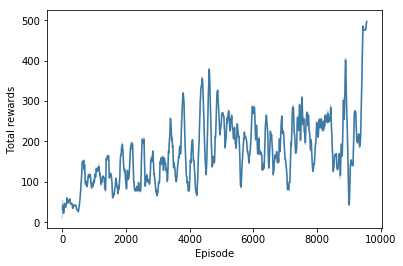

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

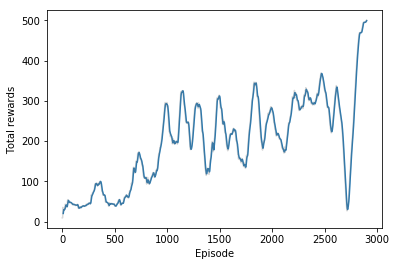

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

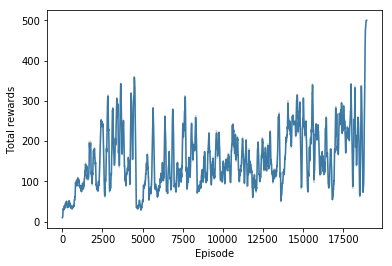

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

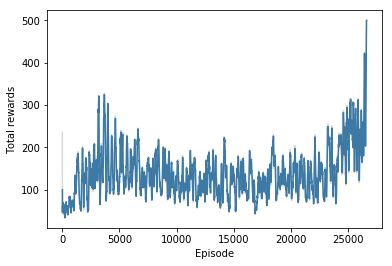

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

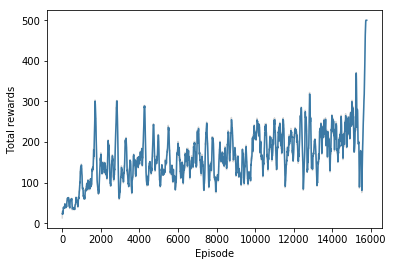

In [44]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

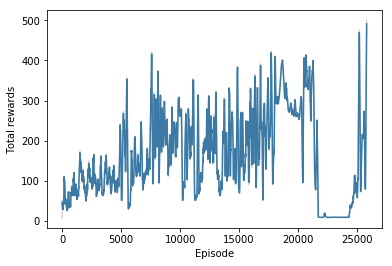

In [42]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

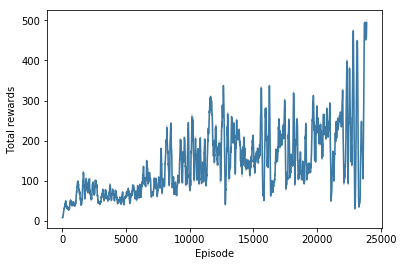

In [40]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

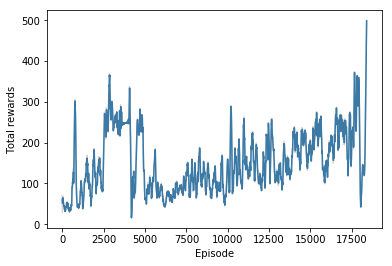

In [37]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

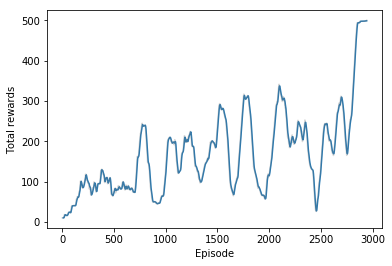

In [221]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

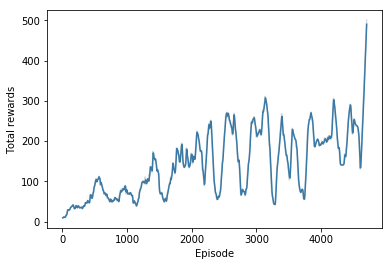

In [216]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

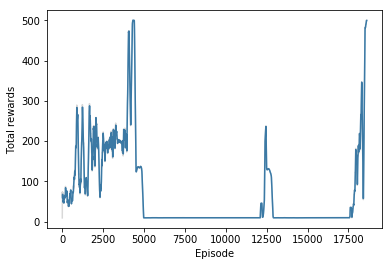

In [203]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

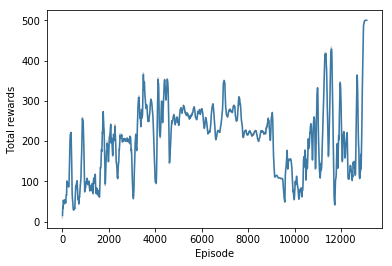

In [188]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

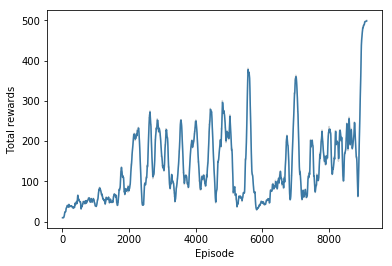

In [165]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

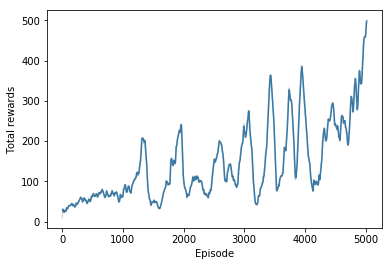

In [126]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

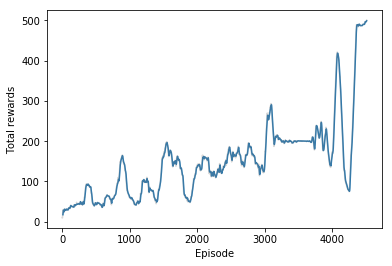

In [109]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

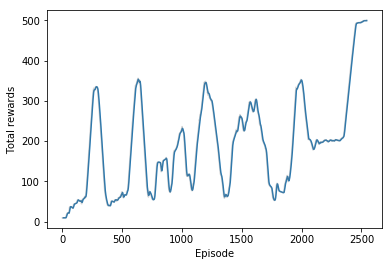

In [84]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

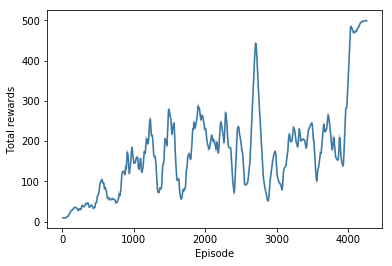

In [64]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

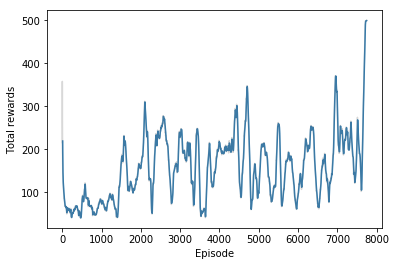

In [44]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

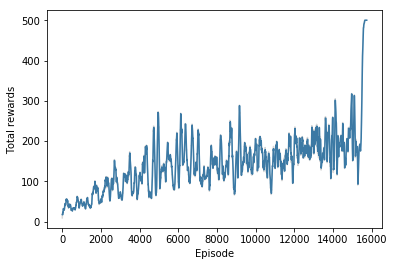

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

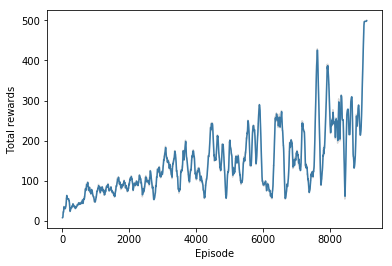

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

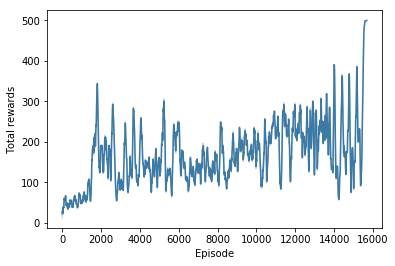

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

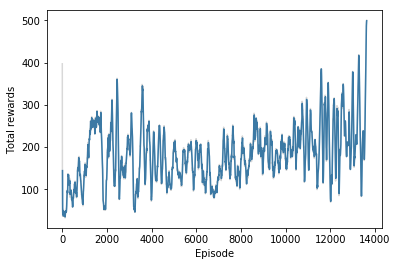

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

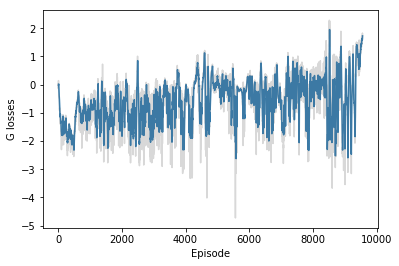

In [36]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

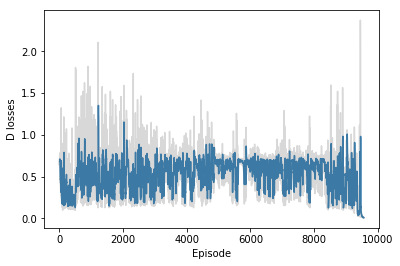

In [37]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

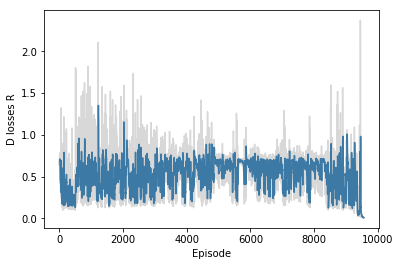

In [38]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

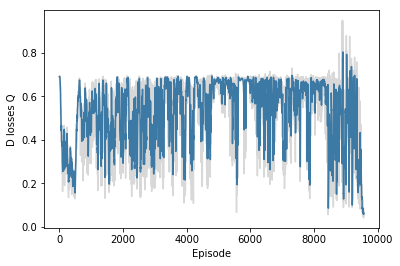

In [39]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.